# [CSL 7340] Programming Assignment - 1

## Instructions:
1. Submit a `.zip` file containing all the working codes (`.py` files). Zip file should be  named in the format `<RollNo1_RollNo2_RollNo3>.zip`. 
2. Submit a report which should contain:
  - Detailed description of what all you have done,
  - Links to the Google-Colab files,
  - Clearly mention the contribution of each group member.
3. Copying from the Internet and/or your classmates is strictly prohibited. Any team found guilty will be awarded a suitable penalty as per IIT rules.




## Flags for flow controll

The `FLAGS` DS is used to store global boolean values that determine the overall behaviour of the project.

In [ ]:
FLAGS = dict()

# If True, this mounts and uses GDrive as persistent storage wherever the notebook supports it.
FLAGS['MOUNT_GDRIVE'] = True

# If True, this will make sure that only the first 25k reviews in the dataset are loaded.
#   Only set to False if you have enough RAM to load the entire dataset in memory.
FLAGS['IMPOSE_25K_REVIEW_COUNT_LIMIT'] = True

# If True, this will cause an error if the dataset containes less than 25k reviews.
FLAGS['ASSERT_AT_LEAST_25K_REVIEW_COUNT'] = False

# If True, this will skip all invalid reviews during the input stage.
#   A review is invalid if its text is 'NaN' or if its overall score is 'NaN'.
FLAGS['SKIP_INVALID_REVIEWS'] = True


# Print flag configuration warnings
error = lambda msg, **printflags: print(f'\x1b[1;33;41m ERROR \x1b[0m: \x1b[1;35m{msg}\x1b[0m', **printflags)
warn = lambda msg, **printflags: print(f'\x1b[1;33;41m Warning \x1b[0m: \x1b[1;35m{msg}\x1b[0m', **printflags)
info = lambda msg, **printflags: print(f'Info: \x1b[1;35m{msg}\x1b[0m', **printflags)
log = lambda tag, msg, **printflags: print(f'{tag}: \x1b[1;35m{msg}\x1b[0m', **printflags)

if not FLAGS['MOUNT_GDRIVE']:
  warn('GDrive mounting disabled. The notebook does not have access to persistent storage and hence will not be able to save any data across different sessions.')
if not FLAGS['IMPOSE_25K_REVIEW_COUNT_LIMIT']:
  warn('Notebook is configured to use pandas without a 25k review limit. This can cause out of memory errors for datasets that are too big.')

## Paths to save/load data

The `PATH` DS is used to store file/folder paths for all data/files in the project. This allows easy migration and saving of important files when needed.

In [ ]:
import pathlib
PATH = dict()

PATH['workdir'] = pathlib.Path('./workdir')

# Mount GDrive if needed
if FLAGS['MOUNT_GDRIVE']:
  PATH['gdrive_mount'] = pathlib.Path('./gdrive')           # Used to mount GDrive (do not use for save/load)
  PATH['gdrive'] = PATH['gdrive_mount'].joinpath('MyDrive') # Used to save/load files in mounted GDrive
  # Mount GDrive
  from google.colab import drive
  drive.mount(str(PATH['gdrive_mount'].resolve()))

# Persistent storage
if FLAGS['MOUNT_GDRIVE']:
  PATH['workdir_save'] = PATH['gdrive'].joinpath('Classroom', 'CSL7340 - Natural Language Processing (Reg.)', 'NLP Assignment 1', 'workdir_save')
else:
  # TODO: use alternative persistent storage if no GDrive
  PATH['workdir_save'] = PATH['workdir']
log(f'Persistent storage at', f'{PATH["workdir_save"]}')

# Make sure all path folders are created
for key, path in PATH.items():
  path.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Persistent storage at: gdrive/MyDrive/Classroom/CSL7340 - Natural Language Processing (Reg.)/NLP Assignment 1/workdir_save


## Install libraries and dependencies

This cell installs the libraries/dependencies required for this notebook.

It can also initialize libraries or required code.

In [ ]:

# Update pytables
# Bugfix: https://stackoverflow.com/questions/54210073/pd-read-hdf-throws-cannot-set-writable-flag-to-true-of-this-array
!pip install -U tables --quiet
import tables
if tables.__version__ == '3.4.4':
  # Restart runtime
  warn("Pytables update requires runtime reboot. Automatically crashing runtime. Please run this cell again.", flush=True)
  import os, time
  time.sleep(1)
  os.kill(os.getpid(), 9)

# NLTK and contractions
!pip install nltk contractions --quiet
# Init. NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')
nltk.download('stopwords')

# Contractions
!pip install contractions --quiet

# FlashText
!pip install flashtext --quiet

# Gensim
!pip install gensim --quiet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Helper functions

### BackedupResource

This class is used to backup and restore file/folder resources.

In [ ]:
import pathlib
from abc import ABC, abstractmethod
class BackedUpResource(ABC):
  def __init__(
      self,
      resource_path: pathlib.Path,
      backup_path: pathlib.Path,
      download_path: pathlib.Path = None,
      logger = {
          'error': error,
          'info': info,
          'warn': warn,
      }
    ):
    # Fix types
    resource_path = pathlib.Path(resource_path)
    backup_path = pathlib.Path(backup_path)
    # If download path not given, use resource path's parent
    if download_path == None:
      download_path = resource_path.parent
    download_path = pathlib.Path(download_path)
    # Check ext.
    if backup_path.suffixes[-2:] == ['.tar', '.gz']:
      self._compress_arg = 'z'
    elif backup_path.suffixes[-1:] == ['.tar']:
      self._compress_arg = ''
    else:
      raise Exception(f'Invalid backup path: \'{backup_path}\'. Only \'.tar.gz\' or \'.tar\' backup file formats supported.')
    # Save params
    self.resource = resource_path
    self.backup = backup_path
    self.download_path = download_path
    self.log = logger
  def exists(self):
    return self.resource.exists() or self.backup.exists()
  @abstractmethod
  def generate(self, resource: pathlib.Path):
    '''
    Implement this to generate the resource.
    '''
    pass
  def _download(self, target, destination: pathlib.Path):
    # create destination dirs
    destination.parent.mkdir(parents=True, exist_ok=True)
    !rsync -ah --progress '{target.resolve()}' '{destination.resolve()}'
  def _upload(self, target, destination: pathlib.Path):
    # create destination dirs
    destination.parent.mkdir(parents=True, exist_ok=True)
    !rsync -ah --progress '{target.resolve()}' '{destination.resolve()}'
  def load(self):
    '''
    Loads the resource from backup or generates it if it doesn't exist.
    Returns the path to the loaded resource.
    Implement the self.generate method.
    '''
    # Declare tarfile path
    tarfile = self.resource.with_name(self.backup.name)
    def _backup():
      # compress resource
      self.log['info'](f'Adding resource \'{self.resource.name}\' to archive.')
      comp_arg = self._compress_arg
      arg_2 = tarfile.resolve()
      file_arg = '.' if self.resource.is_dir() else self.resource.name
      arg_3 = self.resource.resolve() if self.resource.is_dir() else self.resource.parent.resolve()
      !tar cvf{comp_arg} '{arg_2}' -C '{arg_3}' '{file_arg}'
      # upload
      self.log['info']('Uploading archive to backup.')
      self._upload(tarfile, self.backup)
      self.log['info'](f'Resource \'{self.resource.name}\' backed up at: \'{self.backup}\'')
    if self.resource.exists():
      # Resource already exists.
      if not self.backup.exists():
        # Backup resource
        self.log['info'](f'Backing up resource \'{self.resource.name}\' to: \'{self.backup}\'')
        _backup()
    elif self.backup.exists():
      # Load from backup
      self.log['info'](f'Loading resource \'{self.resource.name}\' from backup at: \'{self.backup}\'')
      self.resource.parent.mkdir(parents=True, exist_ok=True)
      self.log['info'](f'Downloading backup file to: \'{tarfile}\'')
      self._download(self.backup, tarfile)
      self.log['info'](f'Extracting backup file to: \'{self.resource}\'')
      # Extract backup
      arg_1 = tarfile.resolve()
      # count files in tar
      file_count = !tar tzf {arg_1} | wc -l
      file_count = int(file_count[0])
      if file_count > 1:
        # make dir
        self.resource.mkdir(parents=True, exist_ok=True)
      comp_arg = self._compress_arg
      dir_arg = self.resource.resolve() if self.resource.is_dir() else self.resource.parent.resolve()
      !tar xvf{comp_arg} {arg_1} -C {dir_arg}
    else:
      # Nothing exists, generate resource
      self.log['info'](f'Generating resource \'{self.resource.name}\'.')
      self.generate(self.resource)
      if not self.resource.exists():
        raise Exception(f'Cannot backup, resource \'{self.resource.name}\' was not generated.')
      _backup()
    return self.resource


class NoGenerateResource(BackedUpResource):
  def generate(self, _):
    raise Exception('NoGenerateResource cannot be generated. Please make sure the file resource or its backup exists.')

### Helper functions

In [ ]:
def get_iter(column):
    return column

## Dataset: 
1. Choose one category from https://nijianmo.github.io/amazon/index.html - amazon product review data.
2. Choose at least 25,000 (reviews). [if no. of reviews > 25k)
3. Review rule, for dataset: 
  - [overall > 3.0] - positive
  - [overall <= 3.0] - negative

For the purpose of this assignment, we will use the 5-core subset of the total data.

### Citation
> **Justifying recommendations using distantly-labeled reviews and fined-grained aspects**

> Jianmo Ni, Jiacheng Li, Julian McAuley

> *Empirical Methods in Natural Language Processing (EMNLP), 2019*

> [pdf](http://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf)

### Select a category

We will select one category to fetch and process reviews from. This selection is stored in `SELECTED_CATEGORY`.



In [ ]:
# There are a total of 29 categories.
import enum
@enum.unique
class DATASET_CATEGORY(enum.Enum):
  AMAZON_FASHION = enum.auto()
  All_Beauty = enum.auto()
  Appliances = enum.auto()
  Arts_Crafts_and_Sewing = enum.auto()
  Automotive = enum.auto()
  Books = enum.auto()
  CDs_and_Vinyl = enum.auto()
  Cell_Phones_and_Accessories = enum.auto()
  Clothing_Shoes_and_Jewelry = enum.auto()
  Digital_Music = enum.auto()
  Electronics = enum.auto()
  Gift_Cards = enum.auto()
  Grocery_and_Gourmet_Food = enum.auto()
  Home_and_Kitchen = enum.auto()
  Industrial_and_Scientific = enum.auto()
  Kindle_Store = enum.auto()
  Luxury_Beauty = enum.auto()
  Magazine_Subscriptions = enum.auto()
  Movies_and_TV = enum.auto()
  Musical_Instruments = enum.auto()
  Office_Products = enum.auto()
  Patio_Lawn_and_Garden = enum.auto()
  Pet_Supplies = enum.auto()
  Prime_Pantry = enum.auto()
  Software = enum.auto()
  Sports_and_Outdoors = enum.auto()
  Tools_and_Home_Improvement = enum.auto()
  Toys_and_Games = enum.auto()
  Video_Games = enum.auto()


# Select a cateogry
SELECTED_CATEGORY = DATASET_CATEGORY.Books


print(f'Total categories: {len(list(DATASET_CATEGORY))}')
log('Selected category', f'{SELECTED_CATEGORY.name}')

Total categories: 29
Selected category: Books


### Prepare dataset files

Create the folder on local machine where the dataset files will be saved.

Save/Load/Generate custom HDF5 format files for quick loading and out-of-core processing.

We use the 5-core subset of the dataset in which each user/item has exactly 5 reviews.

In [ ]:
# Create dataset folder
PATH['dataset_folder'] = PATH['workdir'].joinpath('dataset', SELECTED_CATEGORY.name)
PATH['dataset_folder'].mkdir(parents=True, exist_ok=True)

# Define persistent filename based on flags
DATASET_FILENAME_BASE = f'{SELECTED_CATEGORY.name}_5'
if FLAGS['IMPOSE_25K_REVIEW_COUNT_LIMIT']:
  DATASET_FILENAME_BASE += '.me25k'
if FLAGS['SKIP_INVALID_REVIEWS']:
  DATASET_FILENAME_BASE += '.skip_invalid'

# Log dataset file base name
log('Dataset file base name', DATASET_FILENAME_BASE)

Dataset file base name: Books_5.me25k.skip_invalid


In [ ]:
# Show dataset files in persistent storage
!ls -lh "{PATH['workdir_save']}/{SELECTED_CATEGORY.name}"

total 6.2G
-rw------- 1 root root 5.4M Mar 20 14:43 Books_5.me25k.skip_invalid.pandas.hdf5.tar.gz
-rw------- 1 root root 5.2M Mar 16 21:37 Books_5.me25k.skip_invalid.vaex.hdf5.parts.tar.gz
-rw------- 1 root root 6.2G Mar 16 22:59 Books_5.skip_invalid.vaex.hdf5.parts.tar.gz


#### Define a `BackedUpResource` dataloader to convert dataset to `pandas` HDF5

This is done to quickly load smaller subsets of dataset.

In [ ]:
class pandas_DataLoader(BackedUpResource):
  import gzip, json, pandas as pd, gc
  from tqdm.notebook import tqdm
  def __init__(
      self,
      dataset_file: pathlib.Path,
      backup_path: pathlib.Path,
      dataset_url,
      entry_validator = lambda d: ('overall' in d) and (not (d['overall'] is None)) and ('reviewText' in d) and (not (d['reviewText'] is None)),
      download_path: pathlib.Path = None,
      max_entries = None,
      filter_cols = None,
    ):
    '''
    Converts the dataset from a .json.gz file to a HDF5 file.
    Paramaters: 
      dataset_file        = the file to store dataset in, must have .hdf5 extension
      backup_path         = the backup '.tar.gz' file path
      dataset_url         = url to download the '.json.gz' file
      download_path       = optional, folder to use to download '.json.gz' file in
      entry_validator     = skips loading entries for which this functions returns false
      max_entries         = the number of total entries to convert to hdf5 (from 1st entry to max_entries)
      filter_cols         = the dataset columns to use, all other dataset columns are ignored
    '''
    assert dataset_file.name[-5:] == '.hdf5'
    super().__init__(dataset_file, backup_path, download_path)
    self.max_entries = max_entries
    self.dataset_url = dataset_url
    self.entry_validator = entry_validator
    self.filter_cols = filter_cols
  def _generate(self, source_file, savefile):
    # Code sampled from: https://nijianmo.github.io/amazon/index.html
    i = 0
    invalid = 0
    df = {}
    file = self.gzip.open(source_file, 'rb')
    for rec in file:
      d = self.json.loads(rec)
      # Validate review and skip if invalid
      if not self.entry_validator(d):
        invalid += 1
        continue
      if self.filter_cols != None:
        d = {k:v for k,v in d.items() if k in self.filter_cols}
      df[i] = d
      i += 1
      if i == self.max_entries:
        break
    df = pd.DataFrame.from_dict(df, orient='index')
    df.to_hdf(savefile, key='df', mode='w')
  def generate(self, dataset_file):
    # download '.json.gz' file
    self.download_path.mkdir(exist_ok=True, parents=True)
    downfolder = self.download_path.resolve()
    dataset_url = self.dataset_url
    self.log['info']('Downloading dataset .json.gz file...')
    !cd '{downfolder}' && curl -L -z dataset.json.gz --create-dirs '{dataset_url}' -o dataset.json.gz.temp && mv -f dataset.json.gz.temp dataset.json.gz 2>/dev/null || rm -f dataset.json.gz.temp
    # create dataset folder
    downfile = downfolder.joinpath('dataset.json.gz')
    if not downfile.exists():
      raise Exception(f'Could not download dataset file from: {dataset_url}')
    dataset_file.mkdir(exist_ok=True, parents=True)
    self.log['info']('Generating pandas HDF5 dataset...')
    self._generate(downfile, dataset_file)
    self.log['info'](f'Done.')

# Create dataloader
dataloader = pandas_DataLoader(
  dataset_file=PATH['dataset_folder'].joinpath(DATASET_FILENAME_BASE, 'pandas', f'{DATASET_FILENAME_BASE}.pandas.hdf5'),
  backup_path=PATH['workdir_save'].joinpath(SELECTED_CATEGORY.name, f'{DATASET_FILENAME_BASE}.pandas.hdf5.tar.gz'),
  dataset_url=f'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/{SELECTED_CATEGORY.name}_5.json.gz',
  max_entries=25_000 if FLAGS['IMPOSE_25K_REVIEW_COUNT_LIMIT'] else None
)

### Load dataset

In [ ]:
# Load dataset files
dataset_path = dataloader.load()

# Print dataset files path
log('Dataset path', dataset_path)

# Load dataset from file
import pandas as pd
data = pd.read_hdf(dataset_path.resolve(), key='df', mode='r')

Dataset path: workdir/dataset/Books/Books_5.me25k.skip_invalid/pandas/Books_5.me25k.skip_invalid.pandas.hdf5


### Visualize and pre-process data

Here, we see the data and clean it.

In [ ]:
# Show data
data

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,False,"03 30, 2005",A1REUF3A1YCPHM,0001713353,{'Format:': ' Hardcover'},TW Ervin II,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from,1112140800,NaN,NaN
1,5.0,True,"06 20, 2016",AVP0HXC9FG790,0001713353,NaN,Amazon Customer,The kids loved it!,Five Stars,1466380800,NaN,NaN
2,5.0,True,"01 24, 2016",A324TTUBKTN73A,0001713353,{'Format:': ' Paperback'},Tekla Borner,My students (3 & 4 year olds) loved this book!...,Five Stars,1453593600,NaN,NaN
3,5.0,False,"07 9, 2015",A2RE7WG349NV5D,0001713353,{'Format:': ' Paperback'},Deborah K Woroniecki,LOVE IT,Five Stars,1436400000,NaN,NaN
4,5.0,True,"01 18, 2015",A32B7QIUDQCD0E,0001713353,NaN,E,Great!,Five Stars,1421539200,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2.0,False,"08 8, 2007",A3AD071UEP20WS,0002241277,NaN,Roger Long,As is the case in nearly all James Patterson's...,Over the top,1186531200,NaN,NaN
24996,5.0,False,"07 29, 2007",A2ICV2E9WYCPAB,0002241277,NaN,M. Walach,Maybe the best of the alex cross books! Women ...,great book!,1185667200,NaN,NaN
24997,5.0,False,"07 4, 2007",A2996RENU49PUJ,0002241277,NaN,Des Hume,Kiss the Girls is a roller coaster ride of twi...,An outstanding Read,1183507200,NaN,NaN
24998,5.0,False,"07 3, 2007",A25IPAX2E39FOI,0002241277,NaN,C. Beachy,Alex Cross the Great read. You should read th...,Mystery,1183420800,NaN,NaN


In [ ]:
# Check invalid reviews
print(f'Invalid reviews: {data["reviewText"].isna().sum()}')

Invalid reviews: 0


In [ ]:
# View only overall and reviewText
DATA = data[['overall', 'reviewText']]

# Filter rows with invalid data
DATA = DATA.dropna()

DATA

,overall,reviewText
0,5.0,"The King, the Mice and the Cheese by Nancy Gur..."
1,5.0,The kids loved it!
2,5.0,My students (3 & 4 year olds) loved this book!...
3,5.0,LOVE IT
4,5.0,Great!
...,...,...
24995,2.0,As is the case in nearly all James Patterson's...
24996,5.0,Maybe the best of the alex cross books! Women ...
24997,5.0,Kiss the Girls is a roller coaster ride of twi...
24998,5.0,Alex Cross the Great read. You should read th...


In [ ]:
# View sample text
DATA['reviewText'][:0]

Series([], Name: reviewText, dtype: object)

## Module - 1 (Statistics):
Tasks:- 
1. Explain the text processing pipeline adopted by you.
2. Generate term statistics:
  - Vocabulary size with word frequencies
  - N-grams
  - POS collections
3. Verify Zipf’s law – what is the best fit for your corpus?
4. Which set of terms best describe your corpus? How did you arrive at it?

### Pre-Process and clean text data

This operation includes the following :-
- Removes HTML code.
- Makes everything lower case.
- Expands contractions.
- Removes numbers.
- Removes stop words.
- Removes punctuation symbols.
- Tokenizes sentences.
- Lemmatizes sentences.

#### Declare Pre-Processor functions

In [ ]:
class PreProcessor:
  '''
  Functions to pre-process text review data.
  These functions use vectorization and multiprocessing to speed up pre-processing.
  All functions return lazy results, i.e. computations happen only when results are requested.
  '''
  from bs4 import BeautifulSoup
  import nltk, re, string, contractions
  from nltk.corpus import wordnet
  from nltk.stem import WordNetLemmatizer
  from flashtext import KeywordProcessor
  def __init__(self):
    self.apply_args = dict()
  def lemmatize(self, col_selection):
    '''
    Uses wordnet and nltk to lemmatize the text.
    NOTE: Requires tokenized input.
    Reference: https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258
    '''
    lemmatizer = self.WordNetLemmatizer()
    tagmap = {
          'J': self.wordnet.ADJ,
          'V': self.wordnet.VERB,
          'N': self.wordnet.NOUN,
          'R': self.wordnet.ADV,
      }
    def apply_func(text):
      # Tokenise and find POS tags
      tagged = self.nltk.pos_tag(text)
      # Lemmatize and join final sentence
      return [lemmatizer.lemmatize(p[0], tagmap[p[1][0]]) if p[1][0] in tagmap else p[0] for p in tagged]
    return col_selection.apply(apply_func, **self.apply_args).astype('object')
  def removeStopWords(self, col_selection):
    '''
    Removes all stop words by replacing them with a space ' '.
    '''
    words = nltk.corpus.stopwords.words('english')
    processor = self.KeywordProcessor()
    for w in words:
      processor.add_keyword(w, ' ')
    return col_selection.apply(processor.replace_keywords)
    # matcher = f'{"|".join([self.re.escape(w) for w in words])}'
    # return col_selection.str.replace(matcher, ' ', regex=True)
  def expandContractions(self, col_selection):
    '''
    Expands contractions in a text column.
    Uses contractions and FlashText library.
    Uses vectorized RegExp replace function for fast operation.
    '''
    # Create flashtext KeywordProcessor
    processor = self.KeywordProcessor()
    dicts = (self.contractions.contractions_dict, self.contractions.leftovers_dict, self.contractions.slang_dict)
    for d in dicts:
      for key, value in d.items():
        processor.add_keyword(key, value)
    return col_selection.apply(processor.replace_keywords)
  def removeNumbers(self, col_selection):
    '''
    Removes numbers from a text column.
    Uses vectorized RegExp replace function for fast operation.
    '''
    matcher = r'[^a-zA-z.,!?/:;\"\'\s]'
    return col_selection.str.replace(matcher, ' ', regex=True)
  def stripHtml(self, col_series):
    '''
    Removes HTML code from a text col. of a dataset.
    Uses BeautifulSoup to remove HTML.
    '''
    def apply_func(text):
      soup = self.BeautifulSoup(text, "html.parser")
      return soup.get_text(separator=" ")
    return col_series.apply(apply_func, **self.apply_args)
  def tokenize(self, col_series):
    '''
    Tokenizes a text col. of the dataset into a list of tokens.
    Uses NLTK word tokenizer.
    '''
    def apply_func(text):
      return self.nltk.word_tokenize(text)
    return col_series.apply(apply_func, **self.apply_args).astype('object')
  def join_tokens(self, col_series):
    '''
    Joins input tokens into a sentence.
    '''
    return col_series.apply(lambda r: ' '.join(r), **self.apply_args)
  def toLowerCase(self, col_series):
    '''
    Converts a text column to lower case.
    Uses vectorized functions for fast operation.
    '''
    return col_series.str.lower()
  def removePunctuation(self, col_series):
    '''
    Removes punctuation symbols from a text column.
    Uses vectorized RegExp replace function for fast operation.
    '''
    matcher = f'[{self.re.escape(self.string.punctuation)}]'
    return col_series.str.replace(matcher, ' ', regex=True)
  def clean_and_tokenize_text(self, col_series):
    '''
    Cleans the text column of the dataset.
      Removes HTML code.
      Makes everything lower case.
      Expands contractions.
      Removes numbers.
      Removes stop words.
      Removes punctuation symbols.
      Tokenizes sentences.
      Lemmatizes sentences.
    Returns:
        Lazy col. expression of cleaned text.
    '''
    d = self.stripHtml(col_series)
    d = self.toLowerCase(d)
    d = self.expandContractions(d)
    d = self.removeNumbers(d)
    d = self.removePunctuation(d)
    d = self.removeStopWords(d)
    d = self.tokenize(d)
    # print(d)
    d = self.lemmatize(d)
    return d
  def pre_process_text(self, col_series):
    '''
    Pre-processes the text column of the dataset.
      Does everything in the clean function above.
      Then joins each tokenized review into a string.
    Returns:
        A col. representing tokenized clean data.
        A col. representing string sentences clean data.
    '''
    tokenized = self.clean_and_tokenize_text(col_series)
    # print(d)
    string = self.join_tokens(tokenized)
    # print(d)
    return tokenized, string

### Visualize pre-processed review data

In [ ]:
pre_processor = PreProcessor()
DATA['pre-processed-tokenized'], DATA['pre-processed'] = pre_processor.pre_process_text(DATA['reviewText'])
DATA['pre-processed']

0        king mouse cheese nancy gurney excellent child...
1                                                 kid love
2        student year old love book definitely recommen...
3                                                     love
4                                                    great
                               ...                        
24995    case nearly james patterson novel villain top ...
24996    maybe best alex cross book woman may want read...
24997    kiss girl roller coaster ride twist turn consi...
24998    alex cross great read read book order write al...
24999    enjoy book immensely true graphic description ...
Name: pre-processed, Length: 25000, dtype: object

### Vocabulary size/frequencies

In [ ]:
corpus = []
for l in DATA["pre-processed-tokenized"]:
    for w in l:
        corpus.append(w)
vocab = set(corpus)
print("Corpus Size:",len(corpus))
print("Vocabulary size:",len(vocab))

Corpus Size: 1071723
Vocabulary size: 31721


In [ ]:
from nltk import ngrams, FreqDist
data_analysis = nltk.FreqDist(corpus)
data_analysis.items()
sorted_words =sorted(data_analysis.items(),key = lambda x:x[1],reverse=True)
print("Words occuring in the corpus in decreasing order of their frequency:")
print(sorted_words)

Words occuring in the corpus in decreasing order of their frequency:
[('book', 31936), ('read', 18290), ('one', 10860), ('story', 10508), ('love', 7478), ('character', 7322), ('like', 6995), ('great', 6808), ('good', 6565), ('time', 6418), ('get', 5917), ('series', 5648), ('well', 5344), ('would', 5245), ('make', 5227), ('write', 5053), ('child', 4496), ('go', 4424), ('first', 4358), ('much', 4207), ('find', 4197), ('end', 4026), ('novel', 3933), ('think', 3788), ('know', 3471), ('really', 3435), ('many', 3413), ('year', 3382), ('narnia', 3368), ('life', 3343), ('way', 3338), ('come', 3327), ('take', 3213), ('also', 3186), ('even', 3185), ('enjoy', 3161), ('world', 3107), ('give', 3105), ('see', 3101), ('could', 3098), ('work', 3035), ('say', 3031), ('play', 2915), ('page', 2768), ('want', 2711), ('little', 2710), ('reader', 2700), ('old', 2662), ('shakespeare', 2591), ('thing', 2555), ('new', 2453), ('people', 2438), ('author', 2421), ('still', 2411), ('plot', 2378), ('two', 2314), ('

Info: Creating dictionary from corpus...
Info: Plotting the top 50 words...


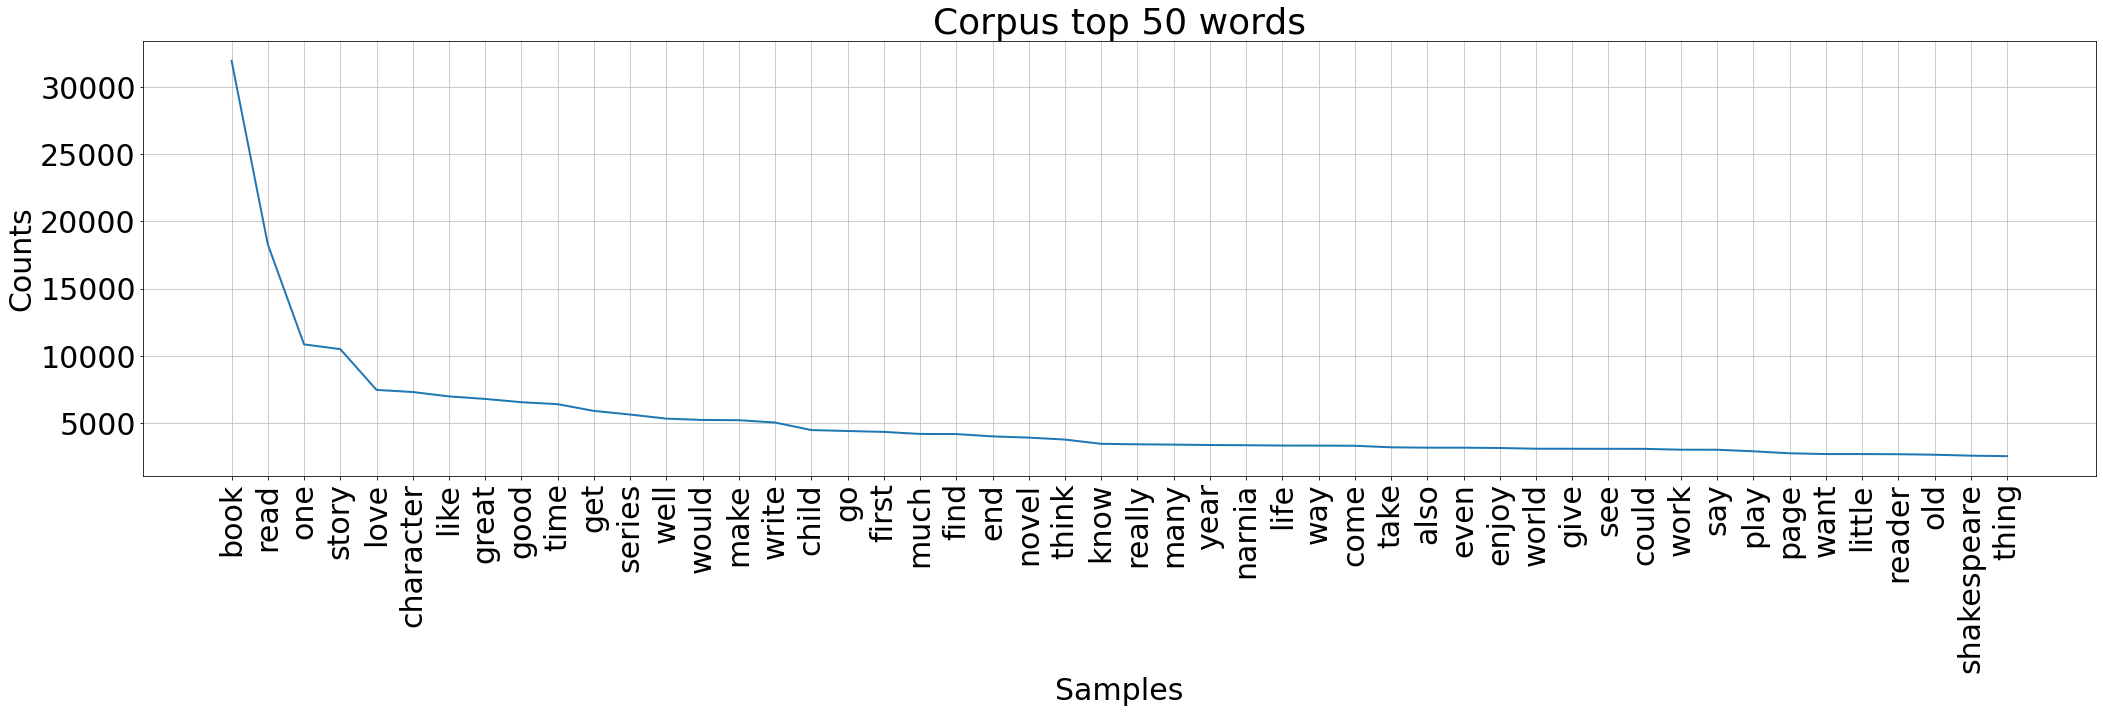

In [ ]:
# Set paramaters
words_to_plot = 50

info('Creating dictionary from corpus...')
from nltk import ngrams, FreqDist
from matplotlib import pylab
import itertools
dist = FreqDist(itertools.chain.from_iterable(get_iter(DATA['pre-processed-tokenized'])))
# Plot frequency
info(f'Plotting the top {words_to_plot} words...')
pylab.rcParams['figure.figsize'] = (35.0, 8.0)
pylab.rcParams["font.size"] = "30"
dist.plot(words_to_plot, title=f'Corpus top {words_to_plot} words')
# Save results
# CORPUS_DICTIONARY = dictionary
CORPUS_FREQDIST = dist

### N-Grams

Info: Creating ngrams(n=2) from corpus...
Info: Plotting the top 50 ngrams(n=2)...


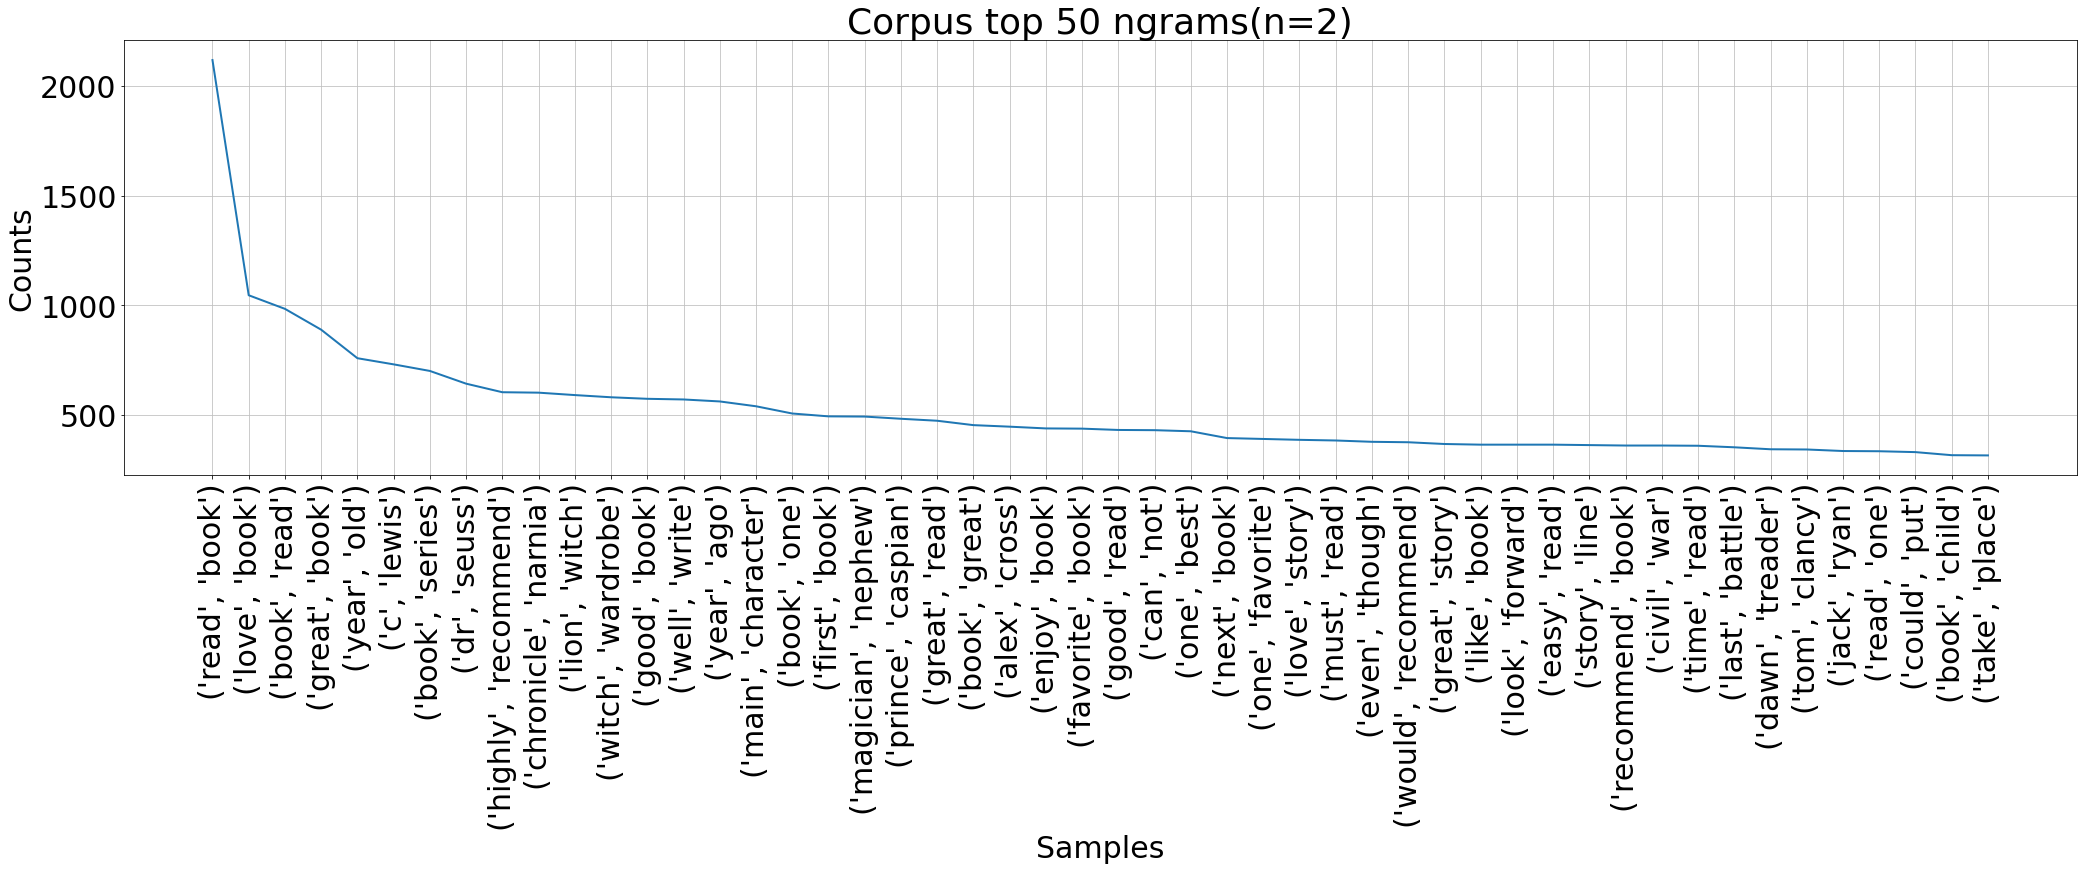

In [ ]:
# Set parameters
n = 2
ngrams_to_plot = 50
column = DATA['pre-processed-tokenized']

# Convert data to ngrams and count frequency
info(f'Creating ngrams(n={n}) from corpus...')
from nltk import ngrams
dist = FreqDist()
for row in get_iter(column):
  ng = ngrams(row, n)
  try:
    dist.update(ng)
  except:
    pass
# Plot frequency
info(f'Plotting the top {ngrams_to_plot} ngrams(n={n})...')
pylab.rcParams['figure.figsize'] = (35.0, 8.0)
pylab.rcParams["font.size"] = "30"
dist.plot(ngrams_to_plot, title=f'Corpus top {ngrams_to_plot} ngrams(n={n})')
# Save results
CORPUS_NGRAM_DIST = dist

### POS Collections

In [ ]:
from collections import Counter
tags = nltk.pos_tag(corpus)
counts = Counter(tag for word, tag in tags)
print(counts) # Print the frequency of each POS

Counter({'NN': 490962, 'JJ': 248158, 'RB': 89193, 'VBP': 65887, 'VB': 50141, 'IN': 25519, 'NNS': 18482, 'CD': 16507, 'VBD': 14847, 'MD': 12845, 'VBN': 8674, 'VBG': 5868, 'VBZ': 5601, 'DT': 3771, 'JJS': 3477, 'JJR': 2006, 'PRP': 2003, 'RBR': 1828, 'FW': 1612, 'NNP': 958, 'CC': 795, 'RP': 746, 'WP': 490, 'RBS': 388, 'WP$': 276, 'WDT': 251, 'WRB': 210, 'UH': 139, 'PRP$': 39, 'POS': 17, 'SYM': 14, 'EX': 7, 'PDT': 5, 'NNPS': 4, "''": 1, '$': 1, 'TO': 1})


In [ ]:
# Print some of the POS collections
print(tags[:10])

[('king', 'NN'), ('mouse', 'NN'), ('cheese', 'JJ'), ('nancy', 'NN'), ('gurney', 'NN'), ('excellent', 'JJ'), ('child', 'NN'), ('book', 'NN'), ('one', 'CD'), ('well', 'NN')]


### Zipf's Law

Text(0.5, 1.0, "Zipf's Law")

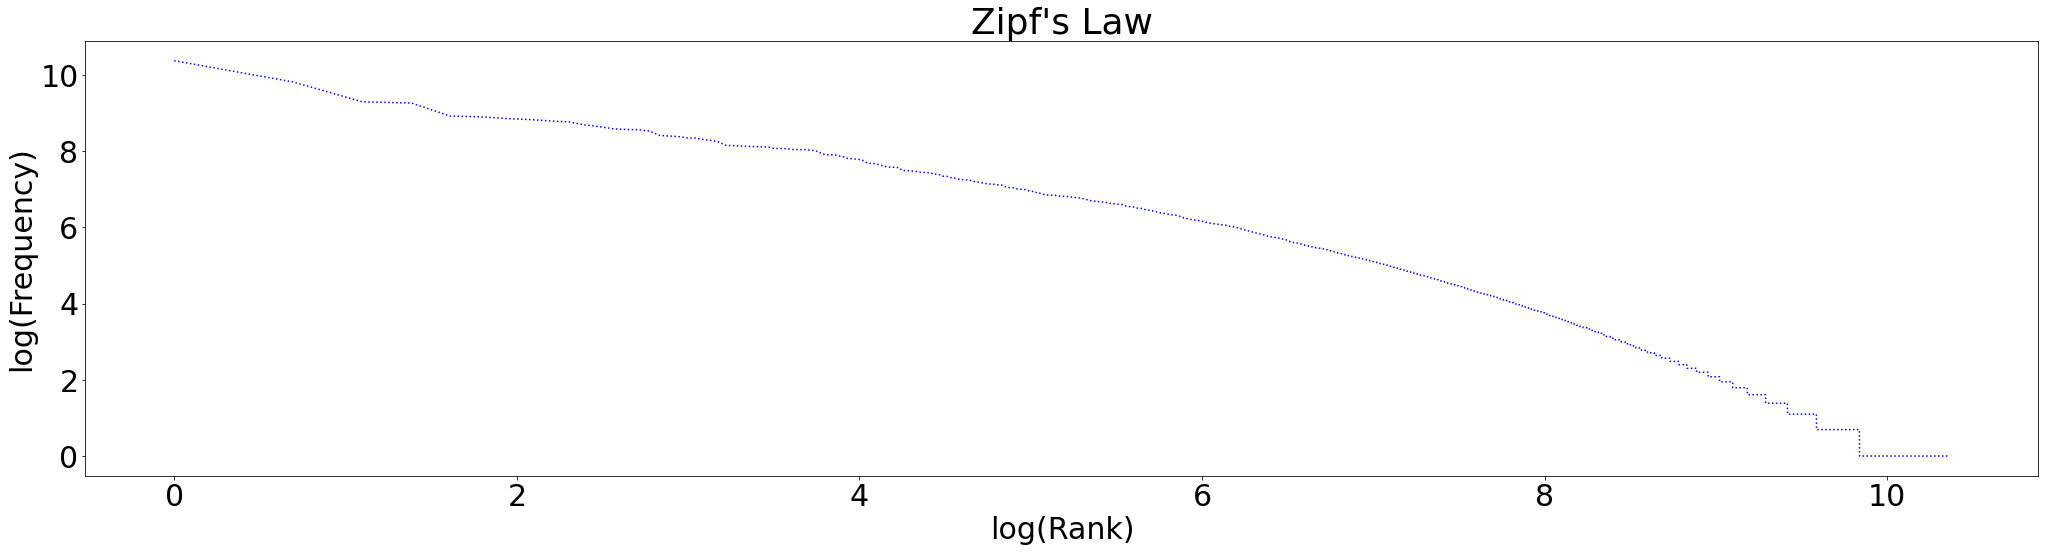

In [ ]:
import matplotlib.pyplot as plt
import math

x = [] 
y = []
for i in range(len(sorted_words)):
    #print(sorted_words[i])
    y.append(math.log(sorted_words[i][1]))
    x.append(math.log(i+1))
plt.plot(x,y,'b:')
plt.xlabel("log(Rank)")
plt.ylabel("log(Frequency)")
plt.title("Zipf's Law")

Slope of the line: -1.5648356790311988
Coefficient of line 15.956012923449933


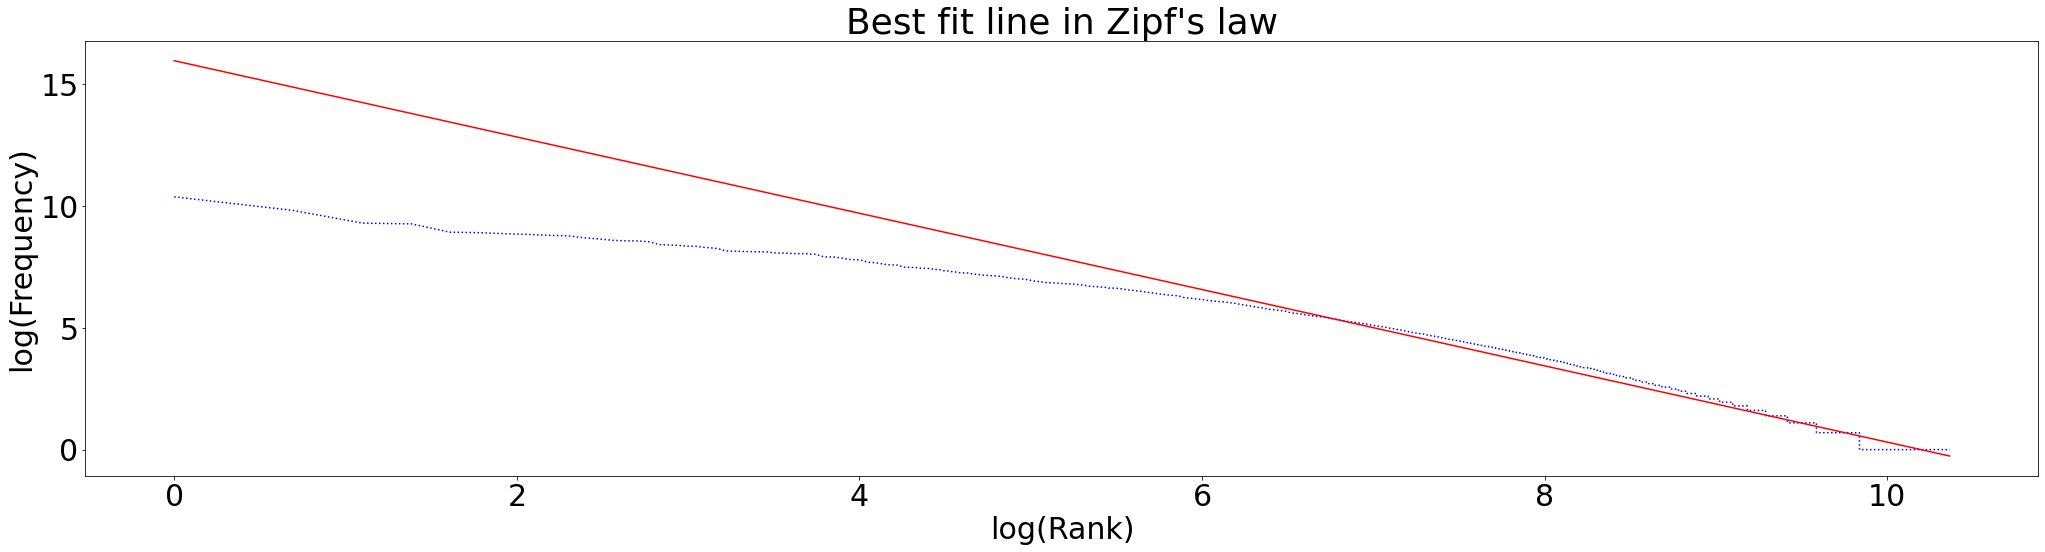

In [ ]:
import numpy as np
x = np.array(x)
y = np.array(y)
m,b = np.polyfit(x,y,1)
plt.plot(x,y,'b:')
plt.plot(x, m*x+b,'r')
plt.xlabel("log(Rank)")
plt.ylabel("log(Frequency)")
plt.title("Best fit line in Zipf's law")
print("Slope of the line:", m)
print("Coefficient of line", b)

## Module - 2 (Sentiment Analysis using statistical NLP):
Tasks:- 
1. Use the following vector space models 
  - CountVectorizer.
  - TF-IDF.
  - Any external vectorizer (cite the original paper).
2. Do sentiment analysis using all (a,b,c) using classical ML techniques 
  - Naive Bayes Model.
  - Decision Tree.
  - Logistic Regression.
3. Report metrics [accuracy, f1 score, confusion matrix] for all the combinations in (1 and 2)
4. Analyse the results. [Report clearly which vector space model is giving better results on each model used]

### Use CountVectorizer to vectorize reviews

We will use `CountVectorizer` from `sklearn`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define dataset iterator
column = DATA['pre-processed']

# Fit CountVectorizer and vectorize data
vectorizer = CountVectorizer(stop_words = 'english')
info('Fitting CountVectorizer to data and vectorizing sentences...')
vectorized = vectorizer.fit_transform(get_iter(column))

# Show vocabulary
log('Vocabulary size', len(vectorizer.vocabulary_))
print("Vocabulary: ", vectorizer.vocabulary_.keys())

# Show vectorized data
log('Vectorized data', type(vectorized))
print(repr(vectorized))

# Rename vectorized data
count_vectorizer = vectorizer
count_vectorized = vectorized

Info: Fitting CountVectorizer to data and vectorizing sentences...
Vocabulary size: 31491
Vocabulary:  dict_keys(['king', 'mouse', 'cheese', 'nancy', 'gurney', 'excellent', 'child', 'book', 'remember', 'childhood', 'purchase', 'daughter', 'love', 'trouble', 'rude', 'eat', 'consults', 'wise', 'men', 'suggest', 'cat', 'chase', 'away', 'mice', 'nuisance', 'recommend', 'bring', 'dog', 'cycle', 'finally', 'elephant', 'lion', 'dogs', 'story', 'end', 'compromise', 'friendship', 'teach', 'effect', 'relationship', 'picture', 'accompany', 'humorous', 'memorable', 'thrill', 'discover', 'print', 'highly', 'age', 'kid', 'student', 'year', 'old', 'definitely', 'teacher', 'great', 'problem', 'fortunately', 'help', 'solve', 'unfortunately', 'turn', 'want', 'place', 'naughty', 'food', 'beard', 'answer', 'delight', 'long', 'come', 'win', 'loses', 'lose', 'fanciful', 'fiction', 'creative', 'activity', 'language', 'art', 'grade', 'reading', 'parent', 'copy', 'fell', 'apart', 'make', 'giggle', 'share', 'ap

### Use TfidfVectorizer to vectorize reviews

We will use `TfidfVectorizer` from `sklearn`.

This is equivalent to `CountVectorizer` followed by `TfidfTransformer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define dataset iterator
column = DATA['pre-processed']

# Fit TfidfVectorizer and vectorize data
vectorizer = TfidfVectorizer(stop_words = 'english')
info('Fitting TfidfVectorizer to data and vectorizing sentences...')
vectorized = vectorizer.fit_transform(get_iter(column))

# Show vocabulary
log('Vocabulary size', len(vectorizer.vocabulary_))
print("Vocabulary: ", vectorizer.vocabulary_.keys())

# Show vectorized data
log('Vectorized data', type(vectorized))
print(repr(vectorized))

# Rename vectorized data
tfidf_vectorizer = vectorizer
tfidf_vectorized = vectorized

Info: Fitting TfidfVectorizer to data and vectorizing sentences...
Vocabulary size: 31491
Vocabulary:  dict_keys(['king', 'mouse', 'cheese', 'nancy', 'gurney', 'excellent', 'child', 'book', 'remember', 'childhood', 'purchase', 'daughter', 'love', 'trouble', 'rude', 'eat', 'consults', 'wise', 'men', 'suggest', 'cat', 'chase', 'away', 'mice', 'nuisance', 'recommend', 'bring', 'dog', 'cycle', 'finally', 'elephant', 'lion', 'dogs', 'story', 'end', 'compromise', 'friendship', 'teach', 'effect', 'relationship', 'picture', 'accompany', 'humorous', 'memorable', 'thrill', 'discover', 'print', 'highly', 'age', 'kid', 'student', 'year', 'old', 'definitely', 'teacher', 'great', 'problem', 'fortunately', 'help', 'solve', 'unfortunately', 'turn', 'want', 'place', 'naughty', 'food', 'beard', 'answer', 'delight', 'long', 'come', 'win', 'loses', 'lose', 'fanciful', 'fiction', 'creative', 'activity', 'language', 'art', 'grade', 'reading', 'parent', 'copy', 'fell', 'apart', 'make', 'giggle', 'share', 'ap

### External sentence vectorizer

For this, we will use the `sentence-transformers` library.
- https://github.com/UKPLab/sentence-transformers

#### Install dependencies

In [ ]:
!pip install -U sentence-transformers --quiet

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 2.0MB 9.9MB/s 
     |████████████████████████████████| 1.2MB 30.4MB/s 
     |████████████████████████████████| 870kB 53.1MB/s 
     |████████████████████████████████| 3.2MB 52.1MB/s 


#### Use the `average_word_embeddings_glove.840B.300d` vectorizer to vectorize reviews

This model was selected from the following list of models,
- https://www.sbert.net/docs/pretrained_models.html


In [ ]:
from sentence_transformers import SentenceTransformer

# Init. model and let it load its weights
vectorizer = SentenceTransformer('average_word_embeddings_glove.840B.300d')

# Define dataset iterator
column = DATA['pre-processed']

# Vectorize sentences
vectorized = vectorizer.encode(get_iter(column))

# Show vectorized data
log('Vectorized data', type(vectorized))
print(vectorized)
log('Vectorized shape', vectorized.shape)

# Rename vectorized data
external_vectorizer = vectorizer
external_vectorized = vectorized
external_vectorizer_name = 'average_word_embeddings_glove.840B.300d'


Vectorized data: <class 'numpy.ndarray'>
[[-6.7254081e-02  5.3196970e-02 -1.0720996e-01 ...  2.2965303e-02
   7.2761804e-02 -5.6124449e-02]
 [-7.6410003e-02  3.7173498e-01 -4.1215497e-01 ... -5.0465003e-02
   7.1970500e-02  3.6693001e-01]
 [-7.0371881e-02  2.1318087e-01 -2.1258490e-01 ... -1.1080975e-01
   1.6328101e-01 -1.0643287e-01]
 ...
 [-2.0865526e-02  6.6619344e-02 -1.2600735e-01 ...  1.3286167e-02
  -5.8496781e-02 -7.8402705e-02]
 [-5.3709574e-02  2.3539832e-01 -1.4231342e-01 ... -1.4739333e-01
  -8.6885421e-03 -4.1652579e-02]
 [-8.7517150e-02  1.1728994e-01 -1.2758733e-01 ... -7.0569202e-02
   2.7530890e-02  1.2750491e-04]]
Vectorized shape: (25000, 300)


### Visualize data distribution

Sentiment frequency distribution:


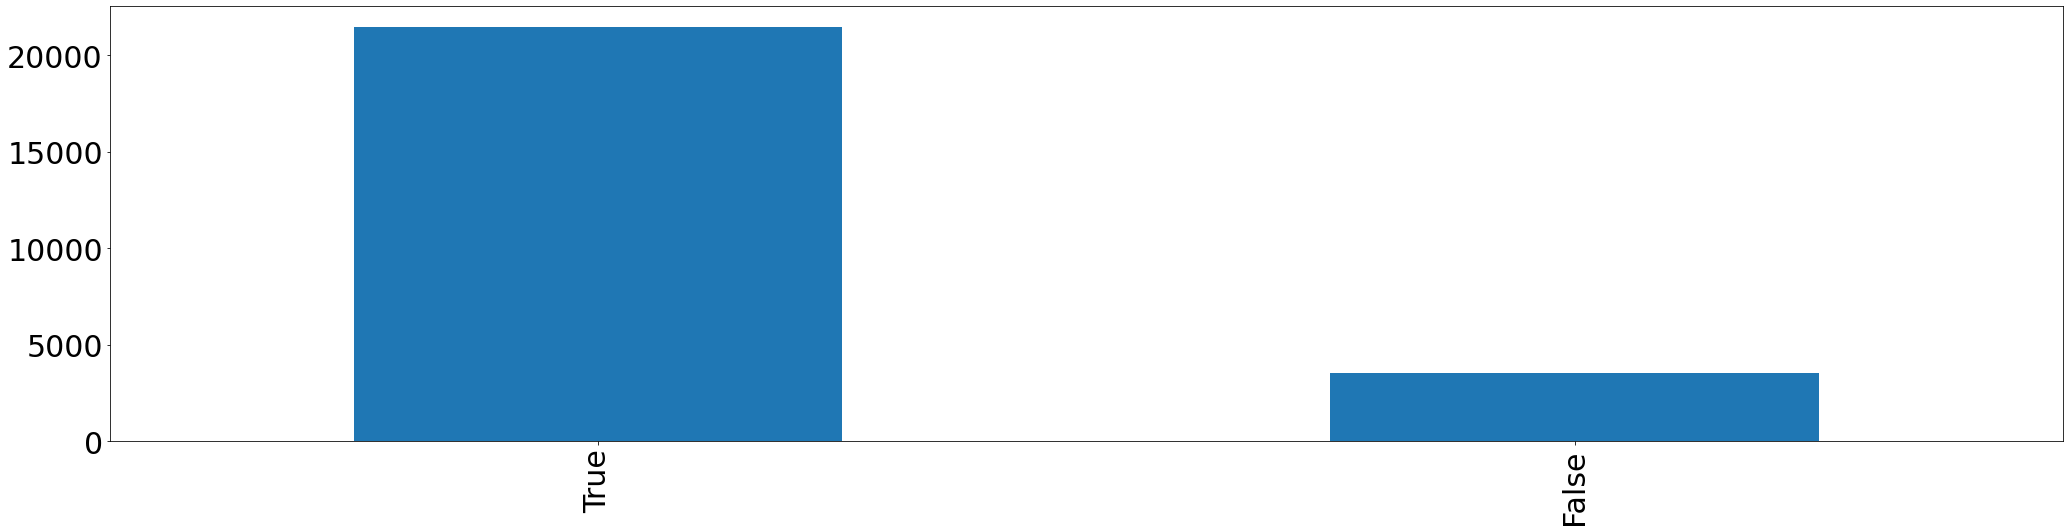

In [ ]:
# Define target sentiment data
Y = DATA['overall'] > 3.0

# Show frequency distribution
print('Sentiment frequency distribution:')
_ = Y.value_counts().plot.bar()

### Set random seed for reproducibility

We use a random seed to make sure that all `train_test_split` calls are deterministic for every model. This allows a fair comparision.

In [ ]:
RANDOM_SEED = 3242941314
log('Random seed', RANDOM_SEED)

Random seed: 3242941314


### Sentiment analysis common code

This functions trains and tests the given model on the given data to print its metrics.

In [ ]:
# Common code for sentiment analysis
def test_model(model_name, vectorizer_name, model, X, Y, random_seed=RANDOM_SEED):
  '''
  Trains and tests given model on given data.
  Also returns the metrics.
  '''
  from sklearn.model_selection import train_test_split
  # Split data
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_seed)
  # Fit the model
  model.fit(X_train, Y_train)
  # Predict
  prediction = model.predict(X_test)
  # Measure metrics
  from sklearn import metrics
  accuracy = metrics.accuracy_score(prediction, Y_test)
  f1_score = metrics.f1_score(prediction, Y_test)
  confusion_matrix = metrics.confusion_matrix(prediction, Y_test, labels=[True, False], normalize='all')
  # Print results
  log('Model', model_name)
  log('Vectorizer', vectorizer_name)
  log('Accuracy', '{:04.2f}%'.format(accuracy*100))
  log('F1 Score', '{:04.2f}%'.format(f1_score*100))
  log('Confusion matrix', '')
  _ = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Positive', 'Negative']).plot()
  # Return metrics
  return {
      'accuracy': accuracy,
      'model_name': model_name,
      'vectorizer_name': vectorizer_name,
      'f1_score': f1_score,
      'confusion_matrix': confusion_matrix,
  }


# Define a results list to accumulate results
sentiment_analysis_results = dict()

### Sentiment analysis using a Naive Bayes Model

We will use the `MultinomialNB` model from `sklearn`.

#### With count vectorized data

Model: Naive Bayes (MultinomialNB)
Vectorizer: Count Vectorizer
Accuracy: 87.71%
F1 Score: 93.04%
Confusion matrix: 


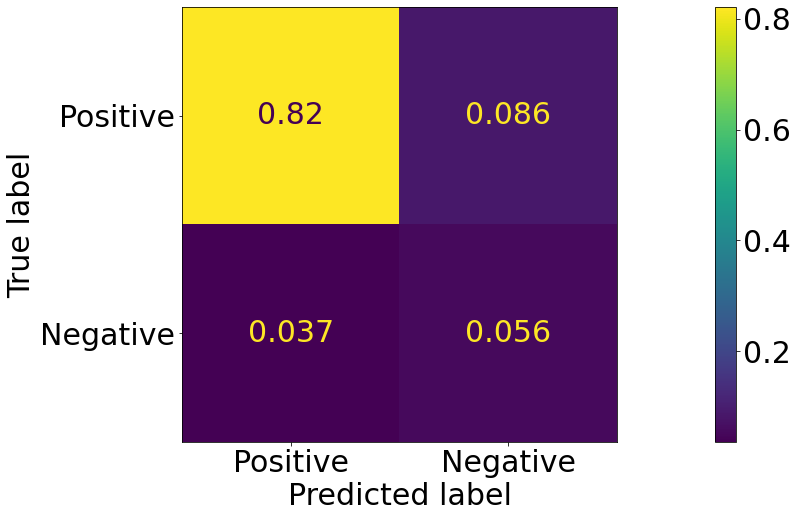

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define target sentiment data
X = count_vectorized

# Create model
model = MultinomialNB()

# Test performance
result = test_model('Naive Bayes (MultinomialNB)', 'Count Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With TF-IDF vectorized data

Model: Naive Bayes (MultinomialNB)
Vectorizer: TF-IDF Vectorizer
Accuracy: 85.80%
F1 Score: 92.36%
Confusion matrix: 


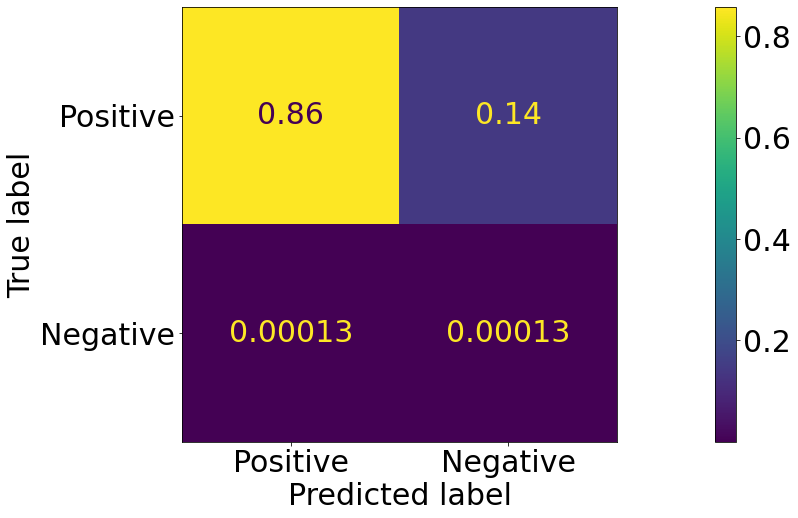

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define target sentiment data
X = tfidf_vectorized

# Create model
model = MultinomialNB()

# Test performance
result = test_model('Naive Bayes (MultinomialNB)', 'TF-IDF Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With external vectorized data

Model: Naive Bayes (MultinomialNB)
Vectorizer: External Vectorizer (average_word_embeddings_glove.840B.300d)
Accuracy: 85.80%
F1 Score: 92.36%
Confusion matrix: 


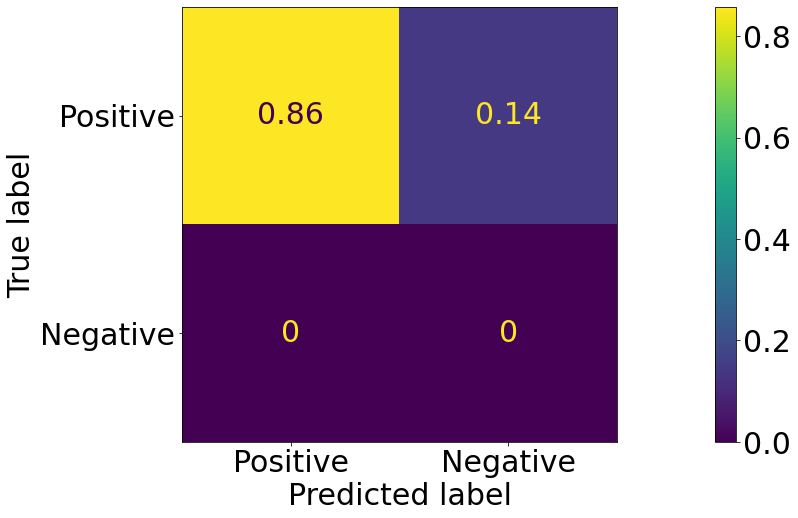

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define target sentiment data
X = external_vectorized

# Normalize data to be in range [0,1], this is done since MultinomialNB only accepts +ve values
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

# Create model
model = MultinomialNB()

# Test performance
result = test_model('Naive Bayes (MultinomialNB)', f'External Vectorizer ({external_vectorizer_name})', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

### Sentiment analysis using `DecisionTreeClassifier`

We will use the `DecisionTreeClassifier` model from `sklearn`.

#### With count vectorized data

Model: DecisionTreeClassifier
Vectorizer: Count Vectorizer
Accuracy: 82.89%
F1 Score: 90.03%
Confusion matrix: 


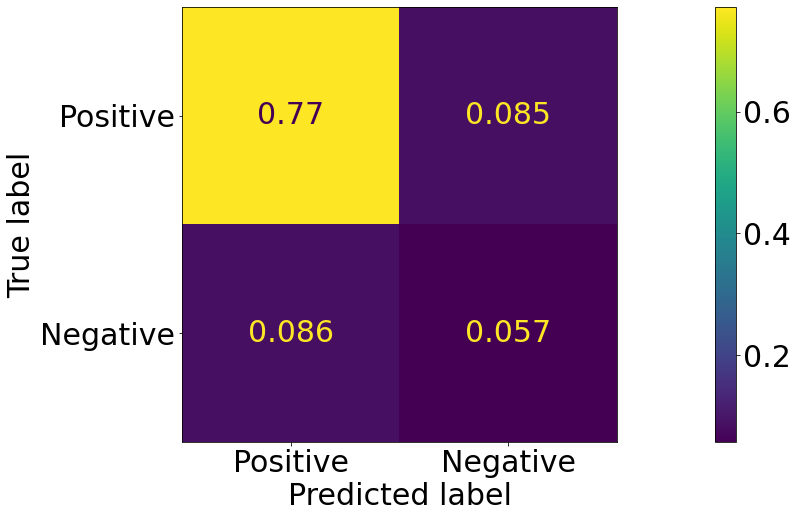

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define target sentiment data
X = count_vectorized

# Create model
model = DecisionTreeClassifier()

# Test performance
result = test_model('DecisionTreeClassifier', 'Count Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With TF-IDF vectorized data

Model: DecisionTreeClassifier
Vectorizer: TF-IDF Vectorizer
Accuracy: 83.47%
F1 Score: 90.48%
Confusion matrix: 


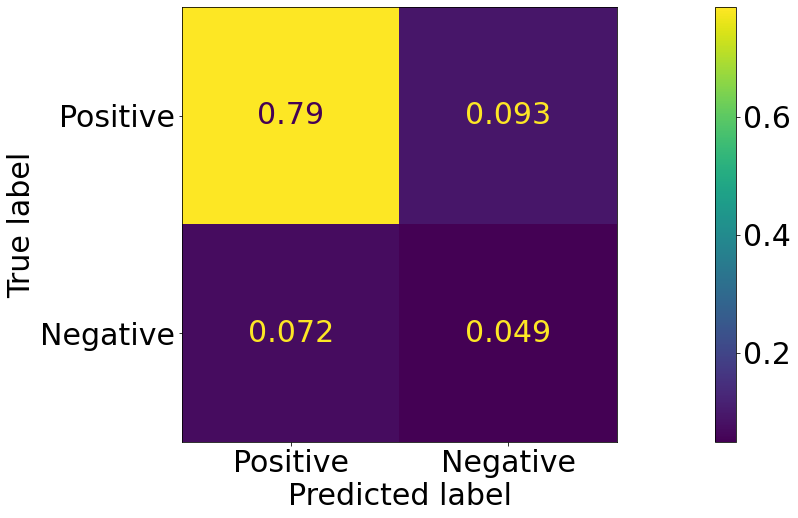

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define target sentiment data
X = tfidf_vectorized

# Create model
model = DecisionTreeClassifier()

# Test performance
result = test_model('DecisionTreeClassifier', 'TF-IDF Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With external vectorized data

Model: DecisionTreeClassifier
Vectorizer: External Vectorizer (average_word_embeddings_glove.840B.300d)
Accuracy: 80.00%
F1 Score: 88.27%
Confusion matrix: 


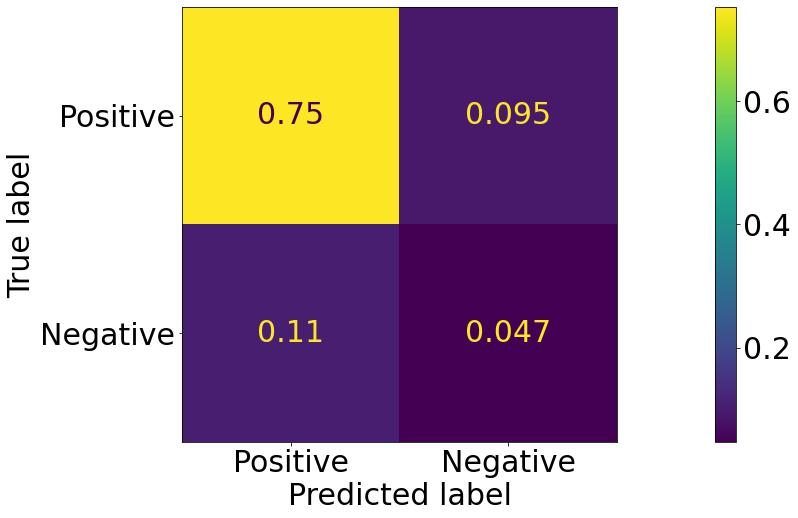

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define target sentiment data
X = external_vectorized

# Normalize data to be in range [0,1], this is done since MultinomialNB only accepts +ve values
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

# Create model
model = DecisionTreeClassifier()

# Test performance
result = test_model('DecisionTreeClassifier', f'External Vectorizer ({external_vectorizer_name})', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

### Sentiment analysis using `LogisticRegression` classifier

We will use the `LogisticRegression` model from `sklearn`.

#### With count vectorized data

Model: LogisticRegression
Vectorizer: Count Vectorizer
Accuracy: 88.49%
F1 Score: 93.49%
Confusion matrix: 


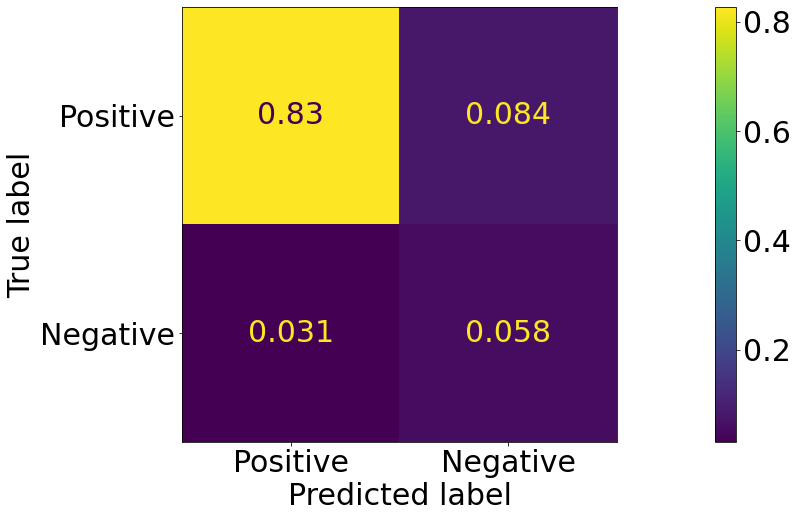

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define target sentiment data
X = count_vectorized

# Create model
model = LogisticRegression(max_iter=1000)

# Test performance
result = test_model('LogisticRegression', 'Count Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With TF-IDF vectorized data

Model: LogisticRegression
Vectorizer: TF-IDF Vectorizer
Accuracy: 88.21%
F1 Score: 93.51%
Confusion matrix: 


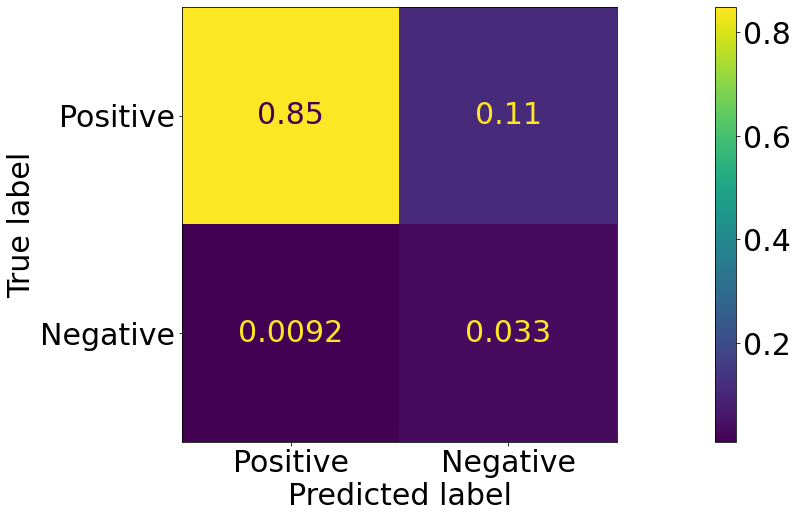

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define target sentiment data
X = tfidf_vectorized

# Create model
model = LogisticRegression(max_iter=1000)

# Test performance
result = test_model('LogisticRegression', 'TF-IDF Vectorizer', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

#### With external vectorized data

Model: LogisticRegression
Vectorizer: External Vectorizer (average_word_embeddings_glove.840B.300d)
Accuracy: 87.93%
F1 Score: 93.26%
Confusion matrix: 


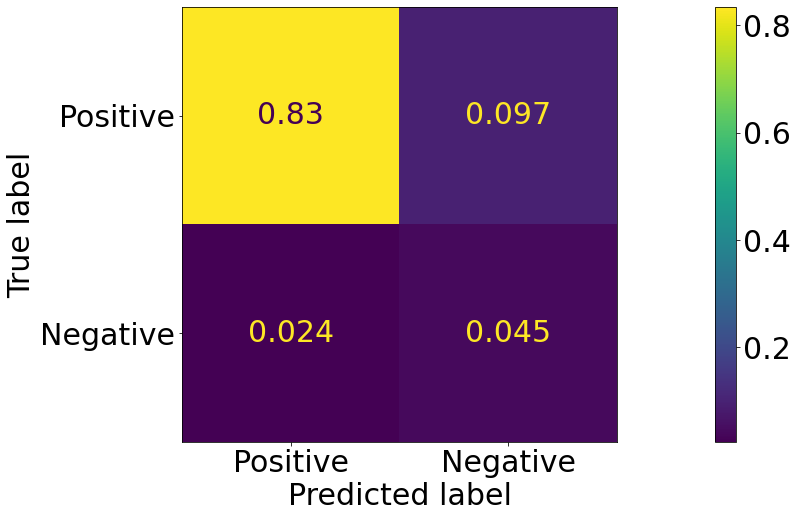

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Define target sentiment data
X = external_vectorized

# Normalize data to be in range [0,1], this is done since MultinomialNB only accepts +ve values
from sklearn.preprocessing import MinMaxScaler
X = StandardScaler().fit_transform(X)

# Create model
model = LogisticRegression(max_iter=1000)

# Test performance
result = test_model('LogisticRegression', f'External Vectorizer ({external_vectorizer_name})', model, X, Y)

# Store results
sentiment_analysis_results[(result['model_name'], result['vectorizer_name'])] = result

### Results of sentiment analysis

#### Best perfromance models per metric

In [ ]:
metrics = ['accuracy', 'f1_score']
best = {
    key: max(sentiment_analysis_results.items(), key=lambda item:item[1][key])
    for key in metrics
}

for k, v in best.items():
  log(f'Best {k} ({"{:04.2f}%".format(v[1][k])})', f'{v[0][0]} model with {v[0][1]}')

Best accuracy (0.88%): LogisticRegression model with Count Vectorizer
Best f1_score (0.94%): LogisticRegression model with TF-IDF Vectorizer


#### Plot perfromance of all models

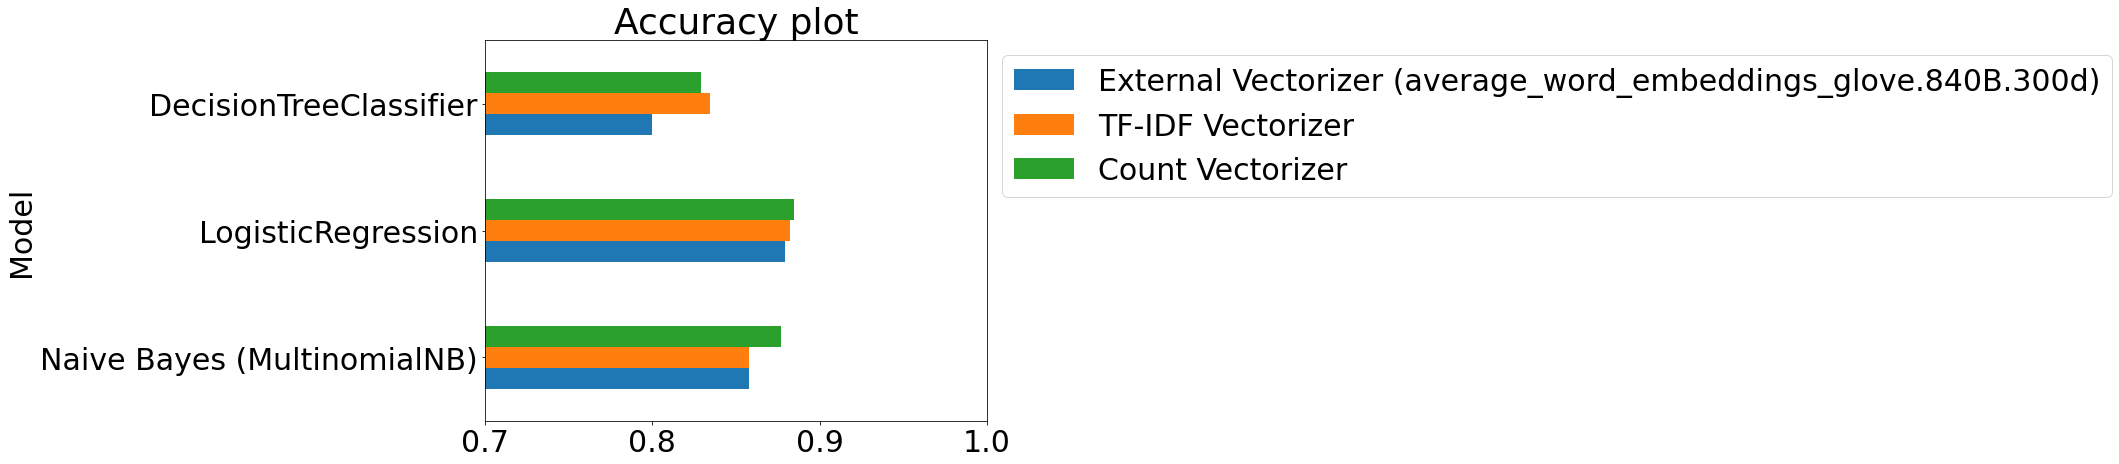

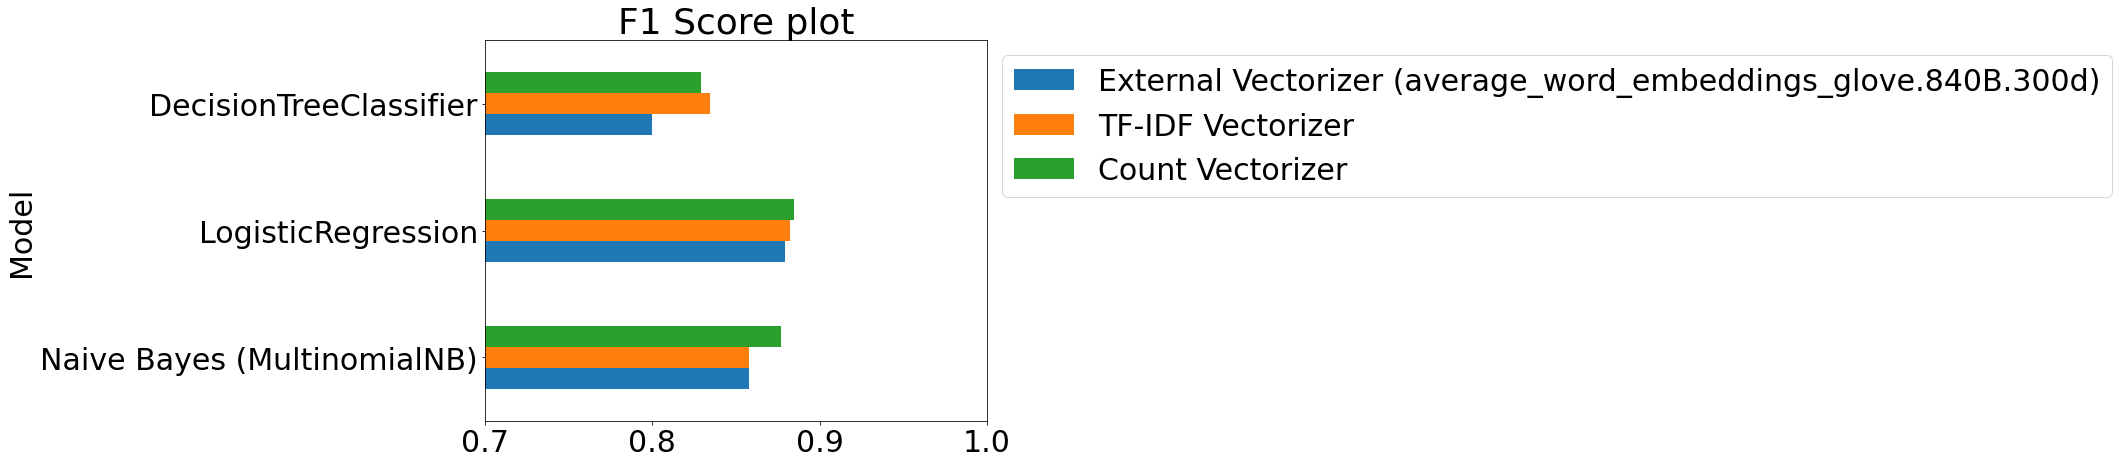

In [ ]:
def plot_metrics(metric_key, **args):
  models, vectorizers = zip(*sentiment_analysis_results.keys())
  models, vectorizers = list(set(models)), list(set(vectorizers))

  df = []
  metric_key = 'accuracy'
  for model in models:
    l = [model]
    for vec in vectorizers:
      x = sentiment_analysis_results[(model,vec)]
      l.append(x[metric_key])
    df.append(l)

  df = pd.DataFrame(df, columns=['Model']+vectorizers)
  df.head()

  ax = df.plot(
      x='Model',
      kind='barh',
      stacked=False,
      **args
  )
  ax.legend(bbox_to_anchor=(1.0, 1.0))
  return ax

# Plot accuracy
plot_metrics(
    'accuracy', 
    title='Accuracy plot', 
    figsize=(9,7),
    xlim=(0.7,1),
    legend='reverse'
  )

# Plot F1 score
plot_metrics(
    'f1_score', 
    title='F1 Score plot', 
    figsize=(9,7),
    xlim=(0.7,1),
    legend='reverse'
  )

## Module - 3 (Topic analysis and topic (attribute) wise sentiment analysis):
Tasks:- 
1. Extract the topics from the reviews using any topic extraction technique of your choice. 
2. Report sentences under each topic.
3. Analyse whether the topics extracted make sense. Justify your claim with some examples.
4. Report topic wise sentiment distribution for the whole repository. Explain the method that you used. Give complete reference of any paper that you use for the purpose. 

For this module, we will use LDA to etract topics for each sentence.
References:
- https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

### Tokenize data

In [ ]:
# Select column
column = DATA['pre-processed']

# Tokenize data
info(f'Tokenizing data...')
import nltk
tokenized = column.apply(nltk.word_tokenize).astype('object')
log('Tokenized data', tokenized)

Info: Tokenizing data...
Tokenized data: 0        [king, mouse, cheese, nancy, gurney, excellent...
1                                              [kid, love]
2        [student, year, old, love, book, definitely, r...
3                                                   [love]
4                                                  [great]
                               ...                        
24995    [case, nearly, james, patterson, novel, villai...
24996    [maybe, best, alex, cross, book, woman, may, w...
24997    [kiss, girl, roller, coaster, ride, twist, tur...
24998    [alex, cross, great, read, read, book, order, ...
24999    [enjoy, book, immensely, true, graphic, descri...
Name: pre-processed, Length: 25000, dtype: object


### Create dictionary, convert to bag of words and train LDA model

In [ ]:
# Since model training takes a long time, we will save a backup for faster loading
import gensim
class LDA_Model_Loader(BackedUpResource):
  def __init__(
      self,
      resource_path: pathlib.Path,
      backup_path: pathlib.Path,
      model_params = {
          'corpus': None,
          'id2word': None,
          'num_topics': 4096,
          'passes': 20,
          'workers': 4,
      },
      *args,
      **kwargs,
    ):
    super().__init__(resource_path, backup_path, *args, **kwargs)
    self.model_params = model_params
  def generate(self, resource: pathlib.Path):
    model = gensim.models.LdaMulticore(**self.model_params)
    resource.mkdir(parents=True, exist_ok=True)
    model.save(str((resource / 'model.pickle').resolve()))
  
# Load/generate LDA model
model_params = {
    'corpus': None,
    'id2word': None,
    'num_topics': 2048,
    'passes': 10,
    'workers': 4,
}
model_basename = f'[{DATASET_FILENAME_BASE}][{"_".join([f"{k}-{v}" for k,v in model_params.items() if not(k in ["corpus", "id2word", "workers"])])}]_lda_model'
loader = LDA_Model_Loader(
    resource_path = PATH['workdir'] / f'{model_basename}',
    backup_path = PATH['workdir_save'] / f'{model_basename}.tar.gz',
    model_params = model_params,
)
if loader.exists():
  # Model already exists, load dictionary and generate bag of words
  info('Saved model exists, loading...')
  model = gensim.models.LdaMulticore.load(str((loader.load() / 'model.pickle').resolve()))
  dictionary = model.id2word
  info('Saved model loaded.')
else:
  # Model needs generation, prepare gensim dictionary
  info(f'Preparing gensim dictionary...')
  import gensim
  dictionary = gensim.corpora.Dictionary(tokenized)
  # Filter extremes
  dictionary.filter_extremes(no_below=1, no_above=0.4)
  info('Gensim dictionary generated.')
  model_params['id2word'] = dictionary

# Show dictionary
log('Dictionary', dictionary)

# Map sentences to bag of words
info(f'Converting tokenized sentences to bag of words...')
bagOfWords = tokenized.apply(dictionary.doc2bow).astype('object')
log(f'Bag of words', bagOfWords)

if not loader.exists():
  model_params['corpus'] = get_iter(bagOfWords)
  model = gensim.models.LdaMulticore.load(str((loader.load() / 'model.pickle').resolve()))

Info: Saved model exists, loading...
Info: Saved model loaded.
Dictionary: Dictionary(31719 unique tokens: ['accompany', 'age', 'also', 'away', 'back']...)
Info: Converting tokenized sentences to bag of words...
Bag of words: 0        [(0, 1), (1, 1), (2, 1), (3, 5), (4, 2), (5, 1...
1                                       [(32, 1), (55, 1)]
2        [(32, 1), (43, 1), (56, 1), (57, 1), (58, 1), ...
3                                                [(32, 1)]
4                                                [(61, 1)]
                               ...                        
24995    [(3, 1), (5, 1), (26, 2), (32, 1), (39, 3), (5...
24996    [(32, 1), (39, 2), (52, 1), (67, 2), (89, 2), ...
24997    [(39, 1), (87, 1), (194, 1), (206, 1), (272, 1...
24998    [(61, 1), (118, 1), (180, 1), (186, 1), (196, ...
24999    [(2, 2), (17, 1), (20, 1), (22, 1), (28, 1), (...
Name: pre-processed, Length: 25000, dtype: object


## Show Learned topics

In [ ]:
log('Topics', model.num_topics)
log('Terms', model.num_terms)
log('Term-Topic matrix shape', model.get_topics().shape)

Topics: 2048
Terms: 31719
Term-Topic matrix shape: (2048, 31719)


In [ ]:
model.show_topics()

[(149,
  '0.032*"well" + 0.024*"year" + 0.020*"interpretation" + 0.020*"play" + 0.019*"ago" + 0.018*"act" + 0.017*"many" + 0.016*"much" + 0.016*"provide" + 0.016*"tattered"'),
 (2014,
  '0.025*"murder" + 0.016*"character" + 0.016*"back" + 0.015*"try" + 0.013*"child" + 0.013*"political" + 0.012*"abundance" + 0.011*"alex" + 0.011*"one" + 0.011*"black"'),
 (1320,
  '0.230*"phrase" + 0.023*"word" + 0.019*"quite" + 0.019*"learn" + 0.018*"child" + 0.017*"go" + 0.017*"also" + 0.016*"page" + 0.014*"concept" + 0.014*"style"'),
 (1616,
  '0.608*"slow" + 0.117*"week" + 0.076*"get" + 0.053*"still" + 0.042*"standard" + 0.033*"think" + 0.018*"seem" + 0.009*"three" + 0.008*"take" + 0.006*"good"'),
 (602,
  '0.079*"smile" + 0.070*"humorous" + 0.045*"christie" + 0.030*"agatha" + 0.029*"life" + 0.024*"divorce" + 0.023*"husband" + 0.020*"love" + 0.018*"autobiography" + 0.018*"gentle"'),
 (1841,
  '0.280*"dragon" + 0.191*"dance" + 0.039*"half" + 0.035*"character" + 0.028*"good" + 0.026*"reluctant" + 0.025

### Extract sentence topics

In [ ]:
# Extract topics and Decode from id to words
info(f'Extracting topics from every sentence...')
topics = bagOfWords.apply(lambda r: [(dictionary[id], prob) for id, prob in model.get_document_topics(r)]).astype('object')
log('Topics', topics)

Info: Extracting topics from every sentence...
Topics: 0        [(make, 0.014548396), (dad, 0.012203737), (ogd...
1                                      [(tire, 0.6668294)]
2        [(answer, 0.33320224), (damage, 0.13737278), (...
3                               [(technology, 0.50024414)]
4                                [(ethnology, 0.50024414)]
                               ...                        
24995          [(recall, 0.04118232), (police, 0.9533581)]
24996    [(recall, 0.073333755), (artist, 0.18592905), ...
24997    [(recall, 0.1600868), (ago, 0.79685634), (aime...
24998    [(used, 0.042209134), (recall, 0.2949213), (vo...
24999                              [(overcome, 0.9931186)]
Name: pre-processed, Length: 25000, dtype: object


### Show topic distribution of a sentence

In [ ]:
# Decide sentence idx to show
sentence_idx = [0, 1, 2, 3, 4, 5, 20, 24000]

bow_it = get_iter(bagOfWords)
tk_iter = get_iter(tokenized)
tp_iter = get_iter(topics)
for i in sentence_idx:
  log('Sentence', ' '.join(tk_iter[i]))
  bow = bow_it[i]
  bow = [(dictionary[id], prob) for id, prob in bow]
  log('Bag of words', bow)
  log('Distribution', tp_iter[i])
  log('-'*20,'-'*20)

Sentence: king mouse cheese nancy gurney excellent child book one well remember childhood purchase daughter love king trouble rude mouse eat cheese consults wise men suggest cat chase away mice cat become nuisance wise men recommend king bring dog chase cat away cycle go mice finally bring back chase away elephant bring chase away lion would chase away dogs story end compromise friendship mouse king story also teach effect relationship picture accompany story humorous memorable thrill discover back print highly recommend child age
Bag of words: [('accompany', 1), ('age', 1), ('also', 1), ('away', 5), ('back', 2), ('become', 1), ('bring', 3), ('cat', 3), ('chase', 5), ('cheese', 2), ('child', 2), ('childhood', 1), ('compromise', 1), ('consults', 1), ('cycle', 1), ('daughter', 1), ('discover', 1), ('dog', 1), ('dogs', 1), ('eat', 1), ('effect', 1), ('elephant', 1), ('end', 1), ('excellent', 1), ('finally', 1), ('friendship', 1), ('go', 1), ('gurney', 1), ('highly', 1), ('humorous', 1), (

## Show topic sentiment distribution

Since there are 2048 topics, we show only the top 50 topics for each case (`+ve` sentiment and `-ve` sentiment).

In [ ]:
dictionary[0]

'accompany'

Info: Calculating weighted sum of topic wise +ve sentiment...



+ve Sentiment per topic: <FreqDist with 1978 samples and 20473 outcomes>
-ve Sentiment per topic: <FreqDist with 1787 samples and 1448 outcomes>


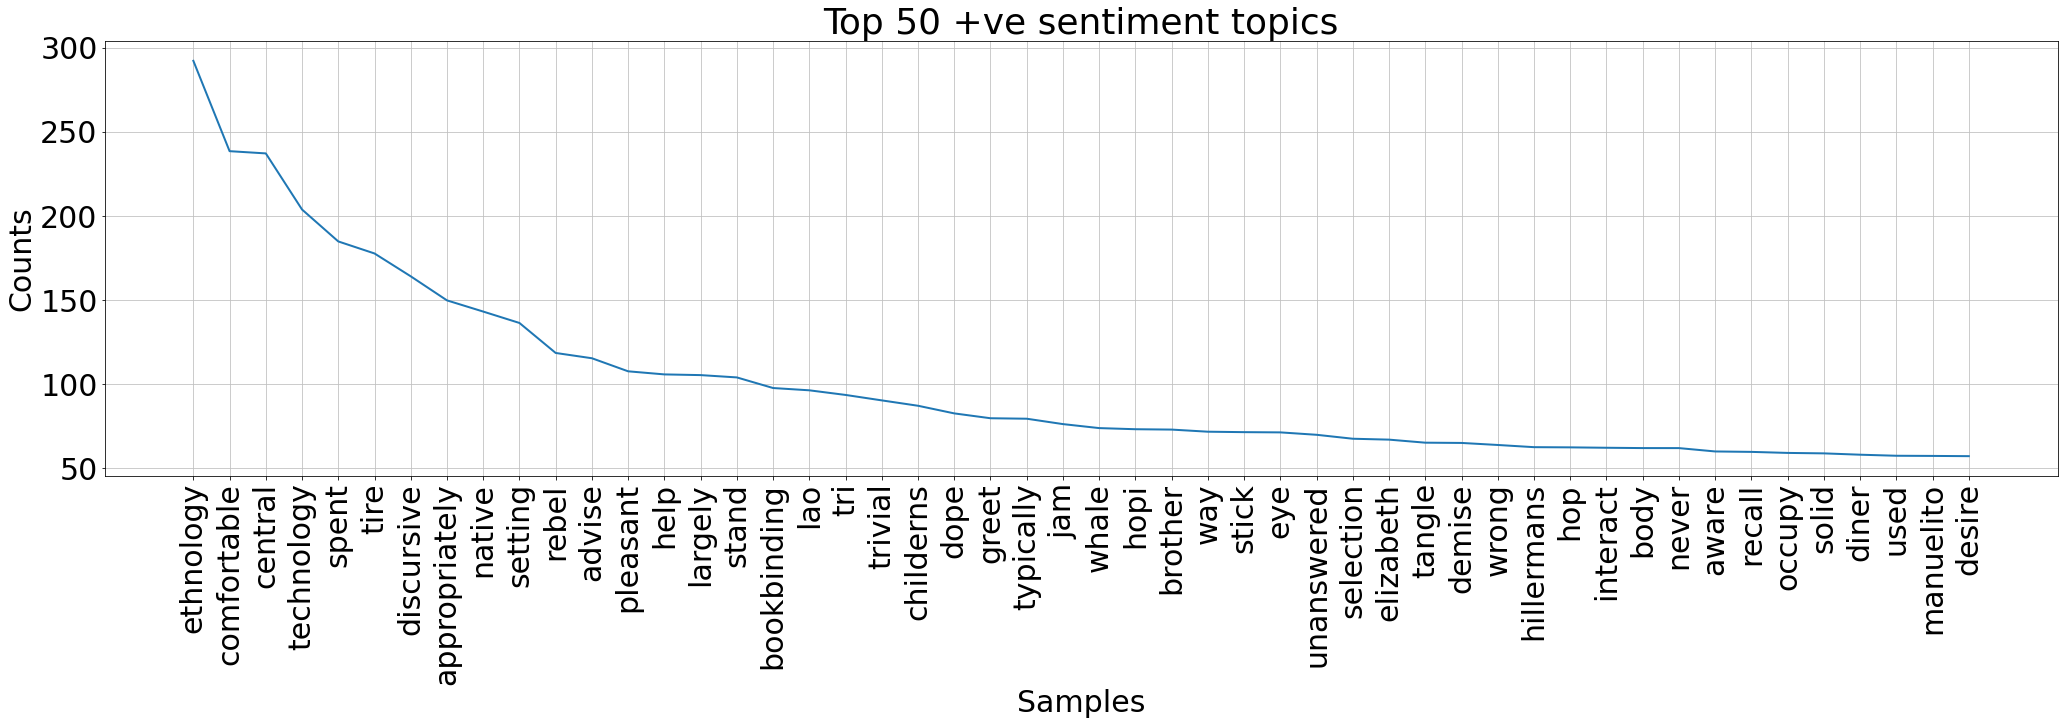

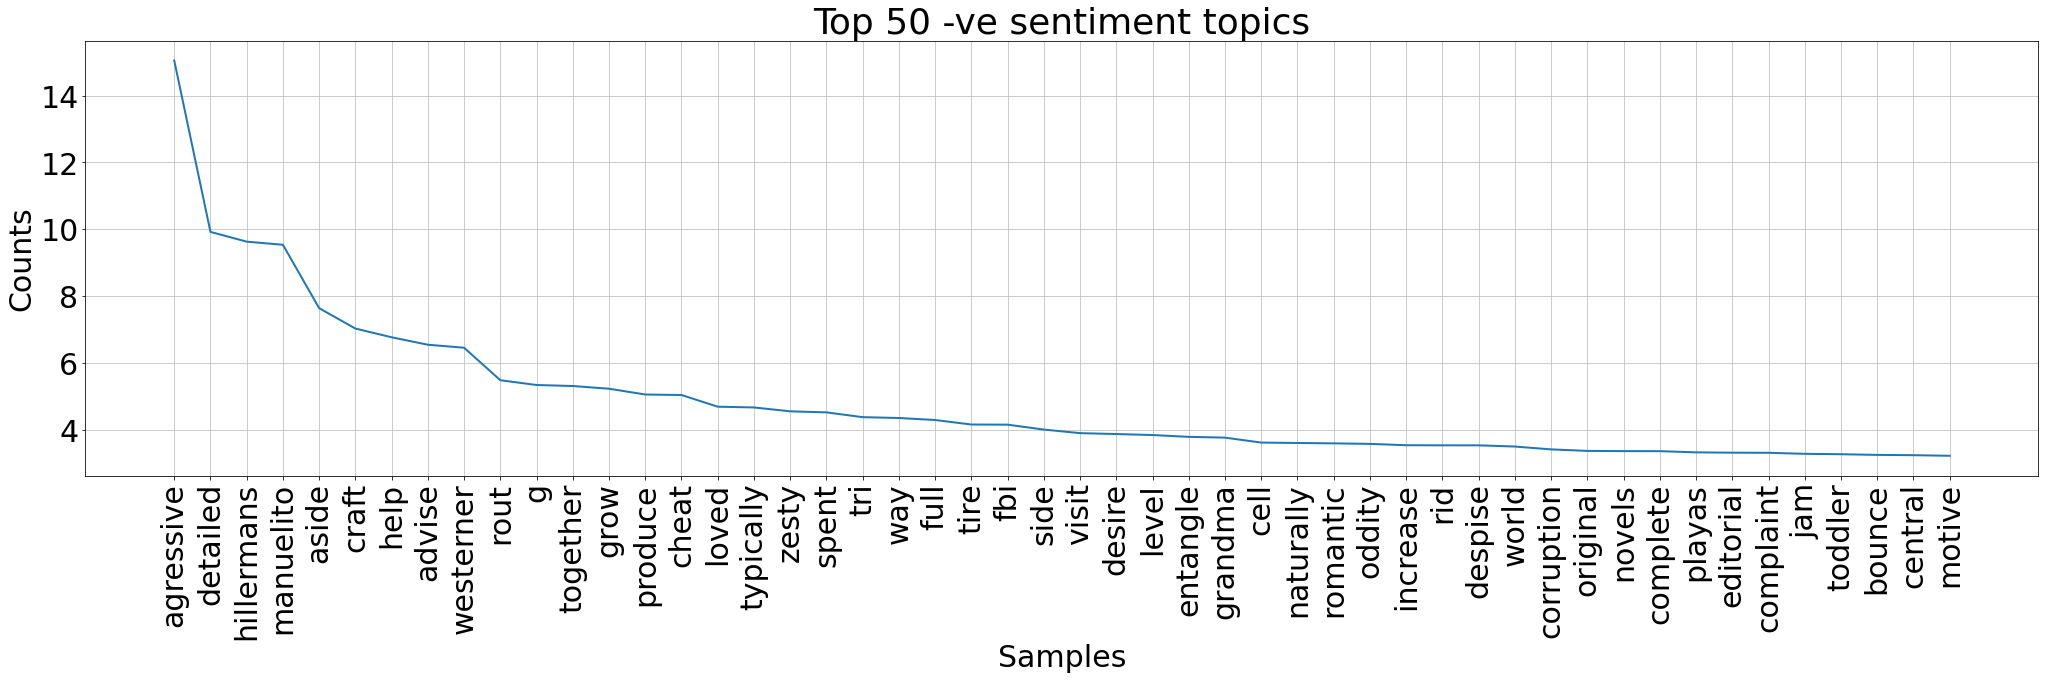

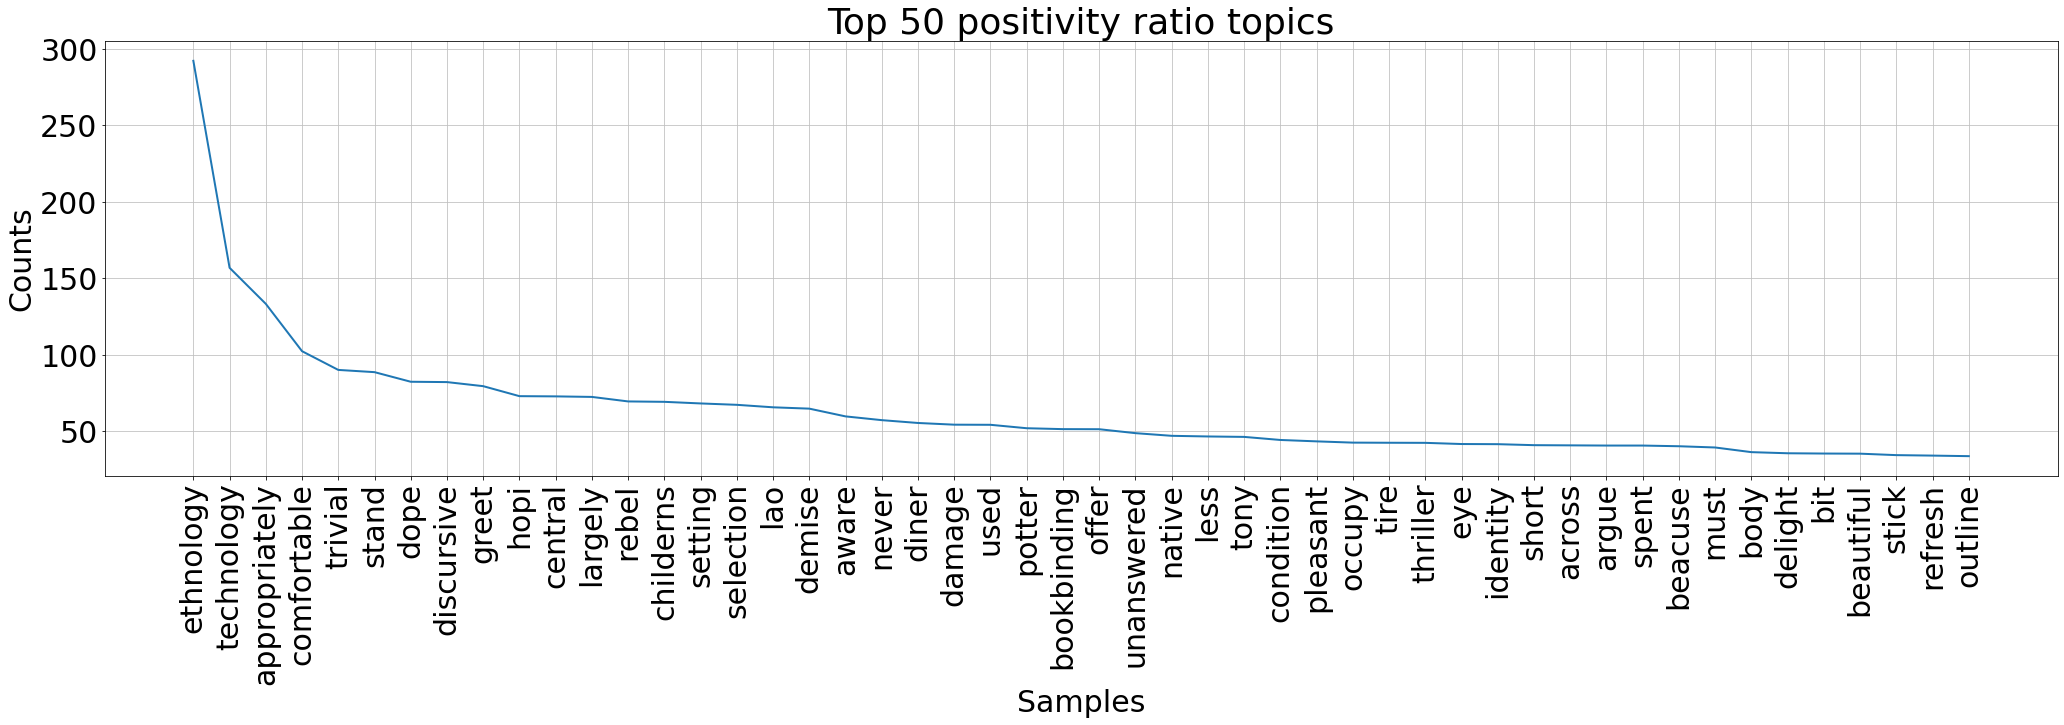

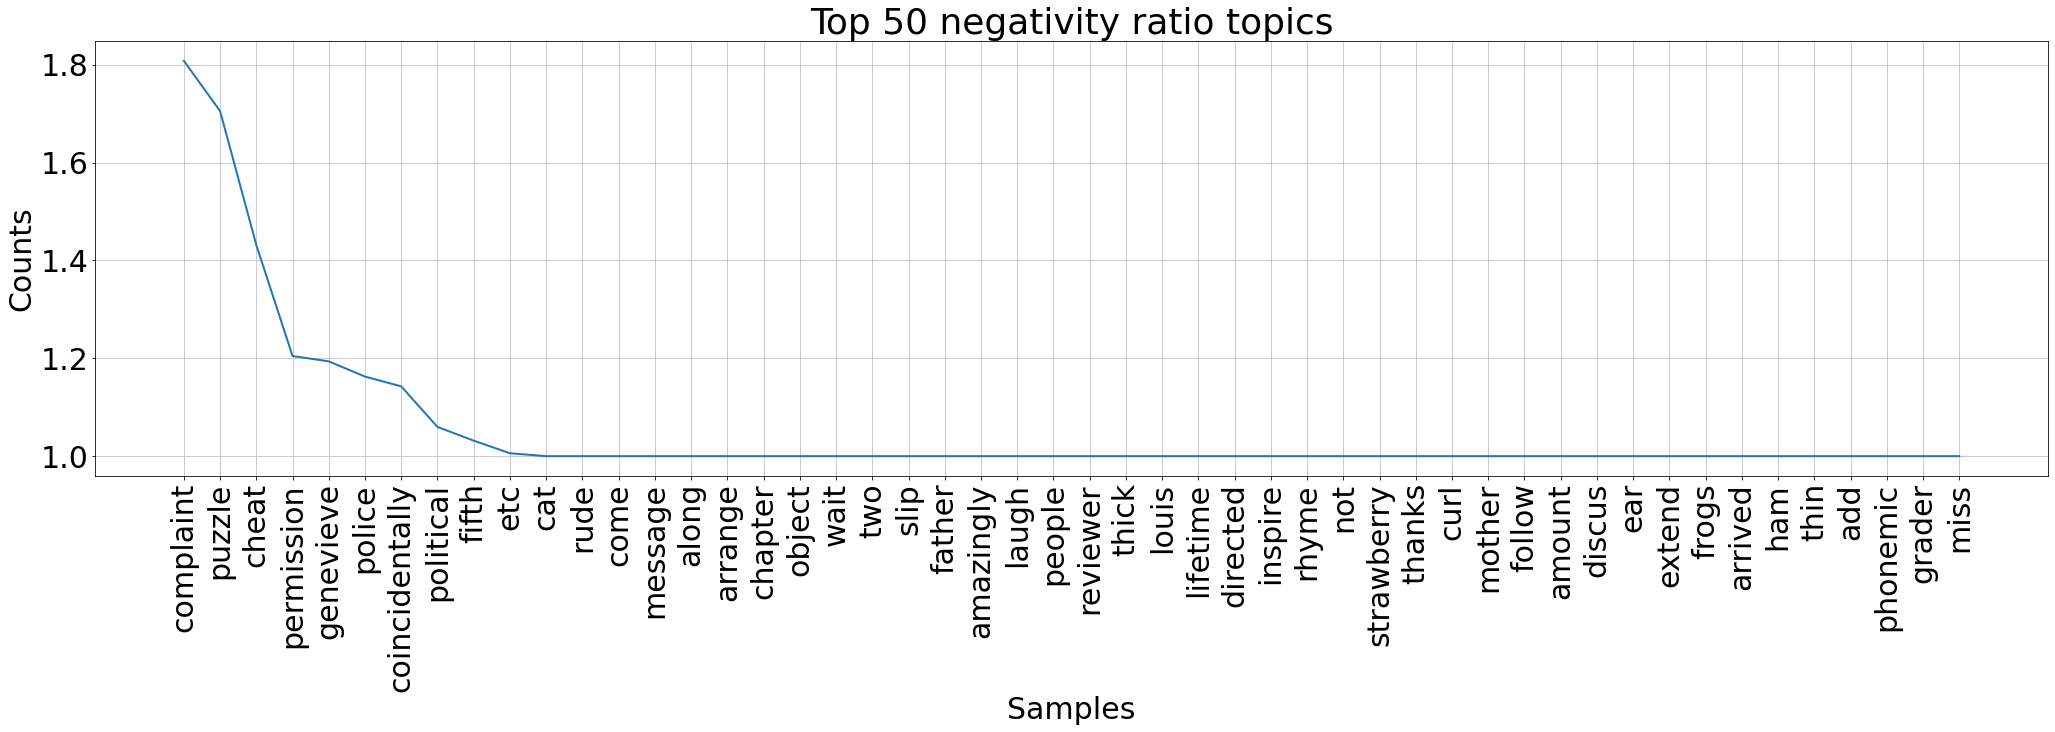

In [ ]:
# Set paramaters
topics_to_plot = 50

# Create topic sentiment matrix
from nltk import FreqDist
senti_pos = FreqDist()
senti_neg = FreqDist()

# calc. sentiment probability summation per topic
from tqdm.notebook import tqdm
info('Calculating weighted sum of topic wise +ve sentiment...')
for idx, senti_val in tqdm(enumerate(sentiment)):
  tp = topics[idx]
  senti = senti_pos if senti_val else senti_neg
  # add topic snetiments
  for id, prob in tp:
    senti[id] += prob
log('+ve Sentiment per topic', senti_pos)
log('-ve Sentiment per topic', senti_neg)

# calculate +ve/-ve ratio which is large for mostly +ve topics
#           -ve/+ve ratio which is large for mostly -ve topics
positivity_ratio = FreqDist()
negativity_ratio = FreqDist()
for i in range(model.num_topics):
  tp = dictionary[i]
  # max() is to deal with 0 division
  wt_pos = max(senti_pos[tp], 1)
  wt_neg = max(senti_neg[tp], 1)
  positivity_ratio[tp] = wt_pos/wt_neg
  negativity_ratio[tp] = wt_neg/wt_pos

# Use FreqDist to easily plot top topics
senti_pos.plot(topics_to_plot, title=f'Top {topics_to_plot} +ve sentiment topics')
senti_neg.plot(topics_to_plot, title=f'Top {topics_to_plot} -ve sentiment topics')

# Plot topic ratios
positivity_ratio.plot(topics_to_plot, title=f'Top {topics_to_plot} positivity ratio topics')
negativity_ratio.plot(topics_to_plot, title=f'Top {topics_to_plot} negativity ratio topics')